# Imports

In [1]:
import os
import re
import glob
import random
import numpy as np
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from PIL import Image
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets 
import braingeneers                                                   # Braingeneers code
from braingeneers.analysis.analysis import SpikeData, read_phy_files
import braingeneers.data.datasets_electrophysiology as ephys
from IPython.display import HTML, display, Javascript, clear_output
from matplotlib.patches import FancyArrow
from matplotlib.colors import LinearSegmentedColormap
import fcm

# Source Code

In [26]:
# Assuming you have the necessary data or class 'sd' defined

def plot_raster(sd, ax):
    idces, times = sd.idces_times()
    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title("Raster Plot")

def interspike(sd, ax):
    isis_raw = sd.interspike_intervals()
    isis = []
    for i in range(len(isis_raw)):   
        isi = isis_raw[i]
        isis = isis + isi[isi < 100].tolist() 
    ax.set_xlim(0, 100)
    ax.hist(isis, bins=50)
    ax.set_xlabel('Time bin(ms)')
    ax.set_ylabel('ISI count')
    ax.set_title("Interspike Intervals")
    
def plot_sttc(sd, ax):
    sttc = np.zeros((sd.N, sd.N))
    for i in range(sd.N):
        for j in range(sd.N):
            sttc[i][j] = sd.spike_time_tiling(i,j)
    im = ax.imshow(sttc)
    ax.set_xlabel("Neuron index")
    ax.set_ylabel("Neuron index")
    ax.set_title("Spike Time Tiling Coefficient Matrix")
    plt.colorbar(im, ax=ax)

def correlation(sd, ax):
    corr = np.zeros((sd.N, sd.N))
    dense_raster = sd.raster(bin_size=1)
    sigma = 5
    dense_raster = gaussian_filter1d(dense_raster.astype(float), sigma=sigma)
    corr = np.corrcoef(dense_raster)
    im = ax.imshow(corr)
    ax.set_xlabel("Neuron index")
    ax.set_ylabel("Neuron index")
    ax.set_title("Correlation Matrix")
    plt.colorbar(im, ax=ax)

def raster_analysis(sd, ax, title, seconds=20):
    idces, times = sd.idces_times()
    pop_rate = sd.binned(bin_size=1)
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float), sigma=sigma)
    t = np.linspace(0, sd.length, pop_rate.shape[0])/1000
    ax.scatter(times/1000, idces, marker='|', s=1, label='Raster Plot')
    ax2 = ax.twinx()
    ax2.plot(t, pop_rate_smooth, c='r', label='Firing Rate')
    ax.set_xlim(0, seconds)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    ax.set_title(title)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

def raster_analysis_bounds(sd, xsize=10, ysize=6, start_time=0, stop_time=None, save_path=None):
    # Zoomed Raster and pop rate
    # Get coordinates for raster
    idces, times = sd.idces_times()

    # Get population rate for everything
    pop_rate = sd.binned(bin_size=1)  # in ms
    # Lets smooth this to make it neater
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float), sigma=sigma)
    t = np.linspace(0, sd.length, pop_rate.shape[0]) / 1000

    # Determine the stop_time if it's not provided
    if stop_time is None:
        stop_time = t[-1]

    # Filter times and idces within the specified start and stop times
    mask = (times >= start_time * 1000) & (times <= stop_time * 1000)
    times = times[mask]
    idces = idces[mask]

    fig, ax = plt.subplots(figsize=(xsize, ysize))

    ax.scatter(times / 1000, idces, marker='|', s=1)
    ax2 = ax.twinx()
    ax2.plot(t, pop_rate_smooth, c='r')

    ax.set_xlim(start_time, stop_time)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

def analyze_and_plot_firing_rates(sd, start, stop, ax=None):
    # Subset the spike data
    sd_start = sd.subtime(start * 1000, stop * 1000)

    def calculate_mean_firing_rates(spike_data):
        mean_firing_rates = []
        for neuron_spikes in spike_data.train:
            num_spikes = len(neuron_spikes)
            time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
            firing_rate = num_spikes / time_duration
            mean_firing_rates.append(firing_rate)

        return np.array(mean_firing_rates)

    # Calculate firing rates
    firing_rates = calculate_mean_firing_rates(sd_start)

    def firing_plotter(sd, firing_rates, ax):
        neuron_x = []
        neuron_y = []
        neuron_amp = []

        for neuron in sd.neuron_data[0].values():
            neuron_x.append(neuron['position'][0])
            neuron_y.append(neuron['position'][1])

        # Define a custom colormap going from pale pink (very low firing rate) to dark red (very high firing rate)
        colormap = LinearSegmentedColormap.from_list('custom_colormap', ['#FFB6C1', '#8B0000'], N=256)

        # Plot scatter points with adjusted colors based on firing rates using the custom colormap
        ax.scatter(neuron_x, neuron_y, s=7.5* firing_rates, c=firing_rates, cmap=colormap, alpha=0.7)

        # Add colorbar for reference
        cbar = ax.figure.colorbar(ax.collections[0])
        cbar.set_label('Firing Rate (Hz)')

    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()

    # Calculate firing rates
    firing_rates = calculate_mean_firing_rates(sd_start)

    # Plot firing rates with adjusted colors
    firing_plotter(sd_start, firing_rates, ax)

    # Return firing rates
    return firing_rates

## Read in data

In [24]:
sd = read_phy_files('/home/jovyan/work/Human_Hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')

/tmp/ipykernel_723519/473825948.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files('/home/jovyan/work/Human_Hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')


# Overview

In [ ]:
# Basic statistics:

num_neurons = sd.N
length_of_recording = sd.length

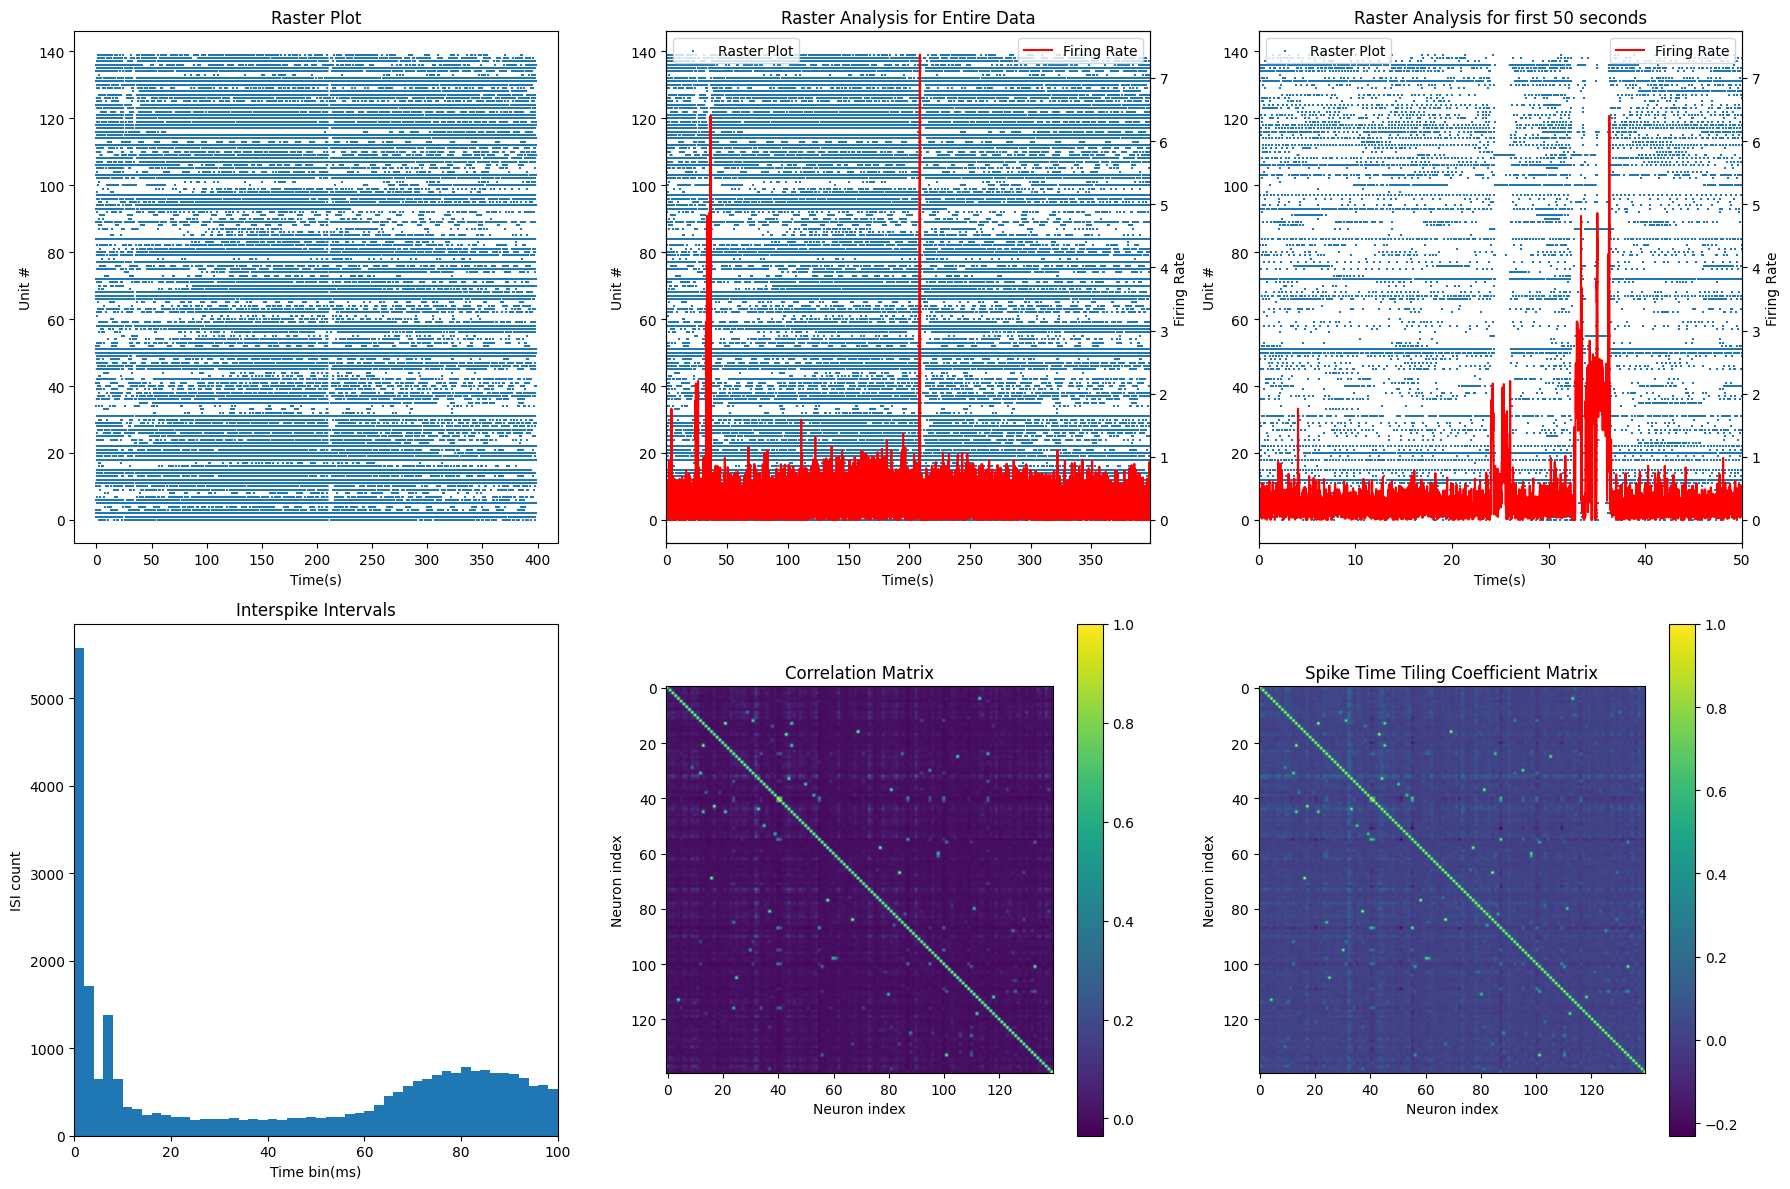

In [4]:
# Create a 2x3 grid for subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Call each function with the corresponding axis from the grid
plot_raster(sd, axs[0, 0])
interspike(sd, axs[1, 0])
correlation(sd, axs[1, 1])
raster_analysis(sd, ax=axs[0, 1], title="Raster Analysis for Entire Data", seconds=sd.length/1000)
raster_analysis(sd, ax=axs[0, 2], title="Raster Analysis for first 50 seconds", seconds=50)
plot_sttc(sd, axs[1, 2])  # Add the new plot

# Adjust layout and show the plot
plt.tight_layout()

plt.savefig("DataOverview")

plt.show()

/tmp/ipykernel_717272/2969079660.py:121: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


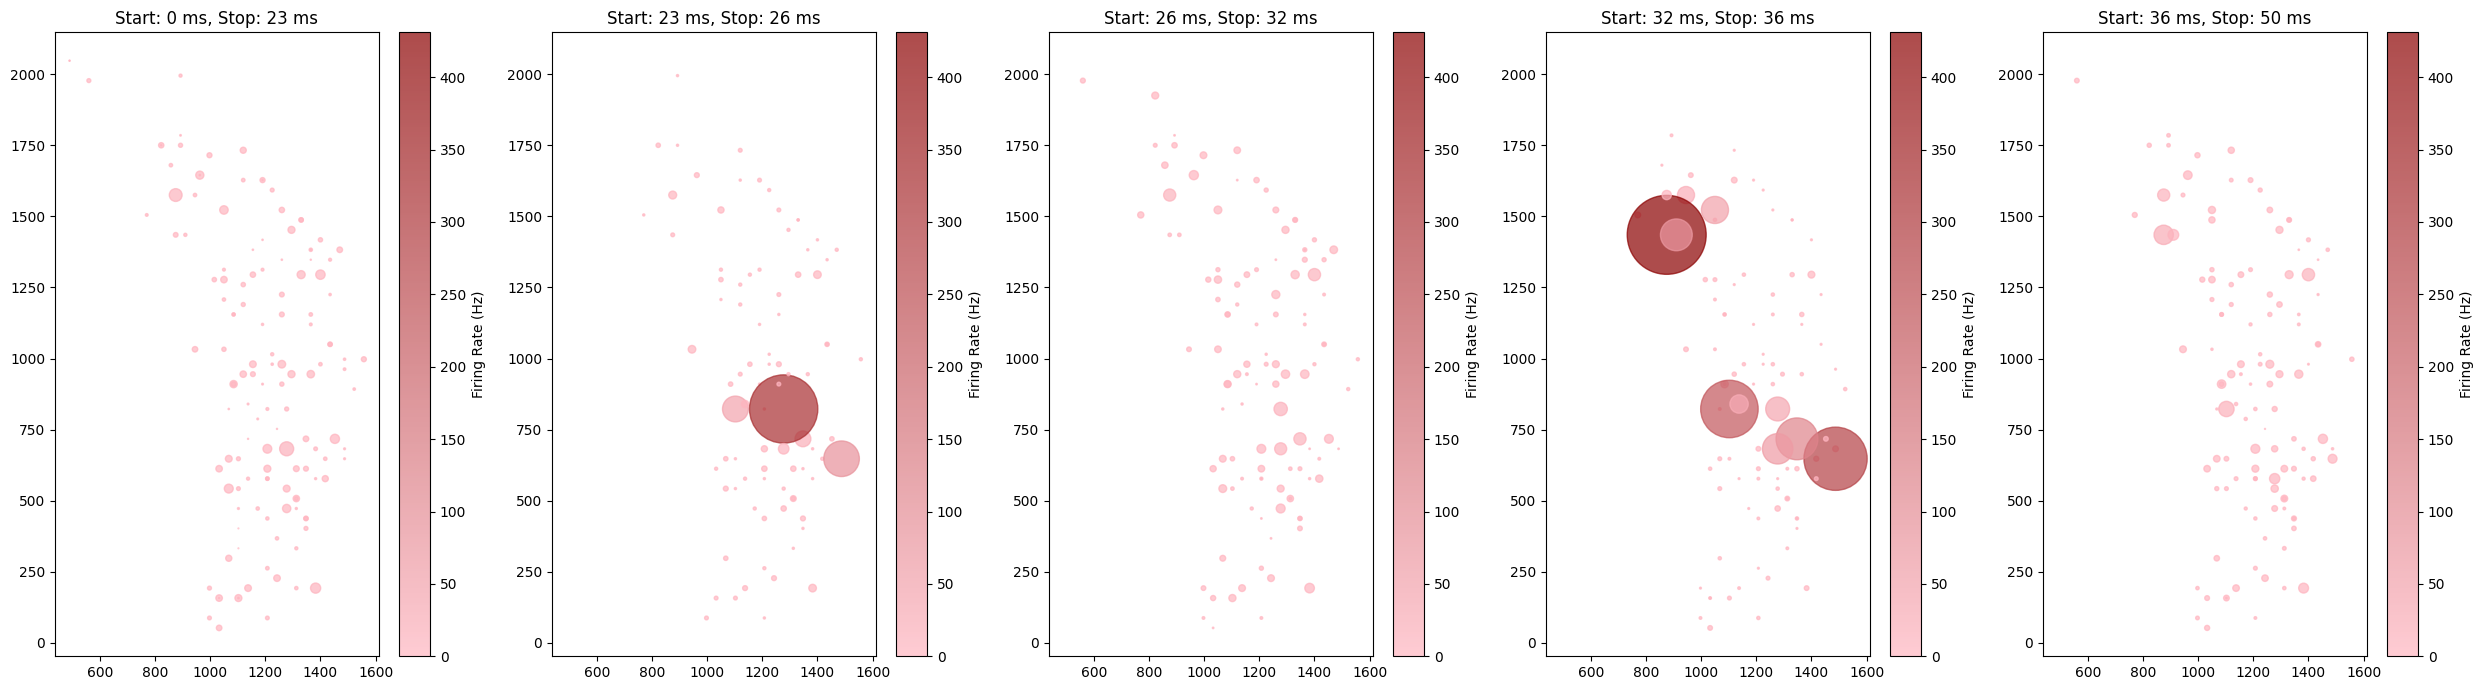

In [5]:
# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 5, figsize=(25, 7))

# Define different start and stop values for each subplot
start_values = [0, 23, 26, 32, 36]
stop_values = [23, 26, 32, 36, 50]

# Create a list to store firing_rates for all subplots
firing_rates_list = []

for i, ax in enumerate(axes):
    # Call the analyze_and_plot_firing_rates function for each subplot with the specified axis
    firing_rates = analyze_and_plot_firing_rates(sd, start_values[i], stop_values[i], ax=ax)
    firing_rates_list.append(firing_rates)
    ax.set_title(f"Start: {start_values[i]} ms, Stop: {stop_values[i]} ms")

# Get the minimum and maximum firing rates across all subplots
global_min = min([firing.min() for firing in firing_rates_list])
global_max = max([firing.max() for firing in firing_rates_list])

# # Create a common colorbar for all subplots using vmin and vmax from the global_min and global_max
# cbar = plt.colorbar(axes[0].collections[0], cax=fig.add_axes([0.91, 0.15, 0.02, 0.7]), orientation='vertical')
# cbar.set_label('Firing Rate (Hz)')

# Set the color limits on the scatter plot directly
for ax in axes:
    ax.collections[0].set_clim(vmin=global_min, vmax=global_max)

plt.tight_layout()

plt.savefig("FiringMapsByTime")

plt.show()

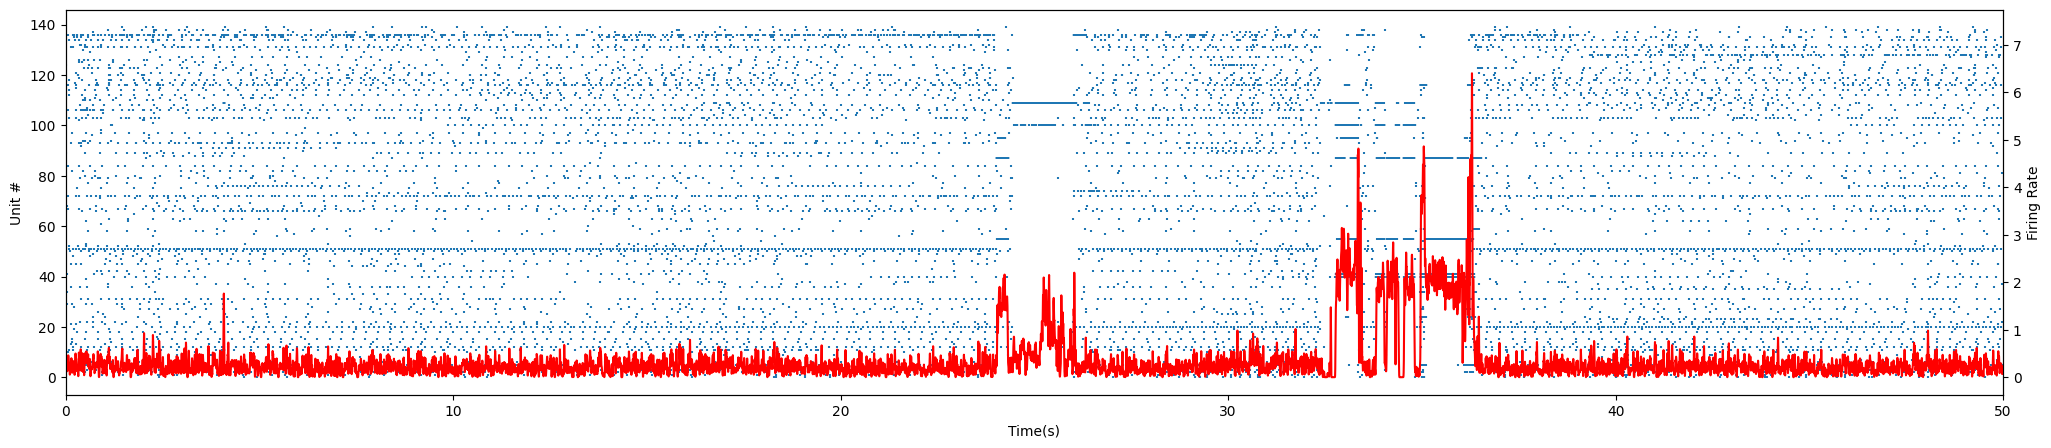

In [6]:
raster_analysis_bounds(sd, xsize=25, ysize=5, start_time=0, stop_time=50, save_path="RasterAnalysisByTime")

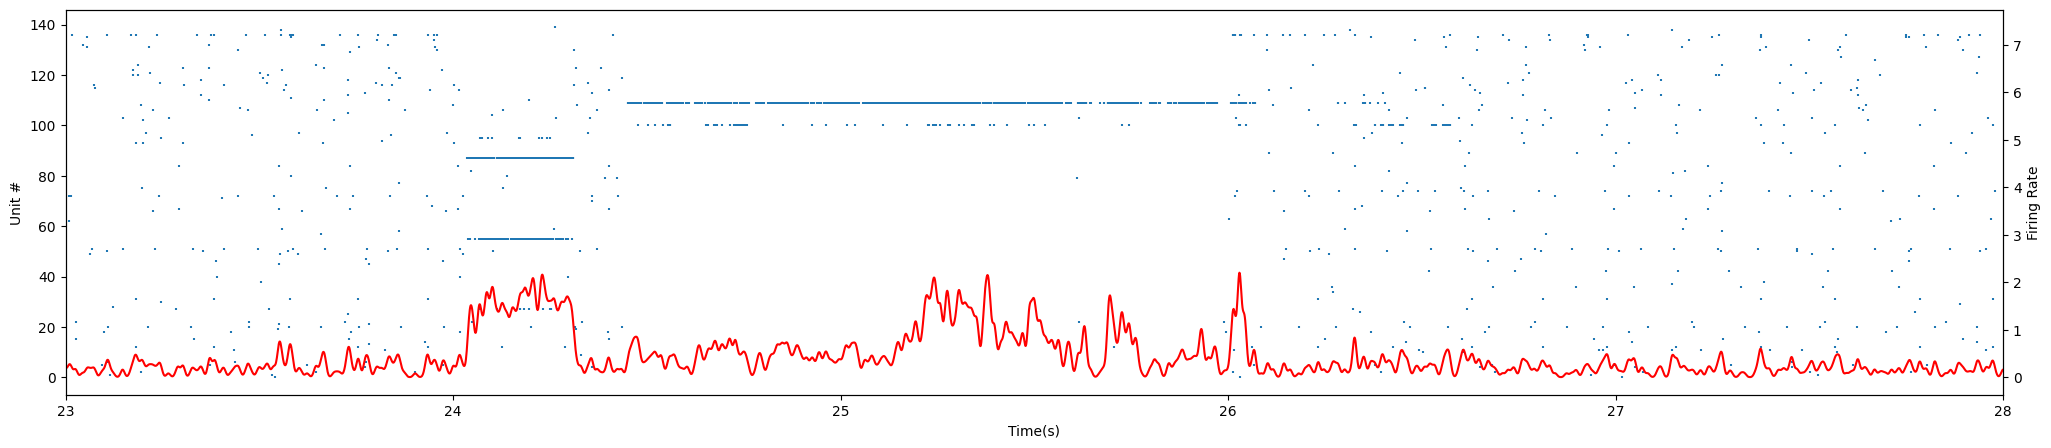

In [7]:
raster_analysis_bounds(sd, xsize = 25, ysize=5, start_time=23, stop_time=28, save_path="Activity23_28")

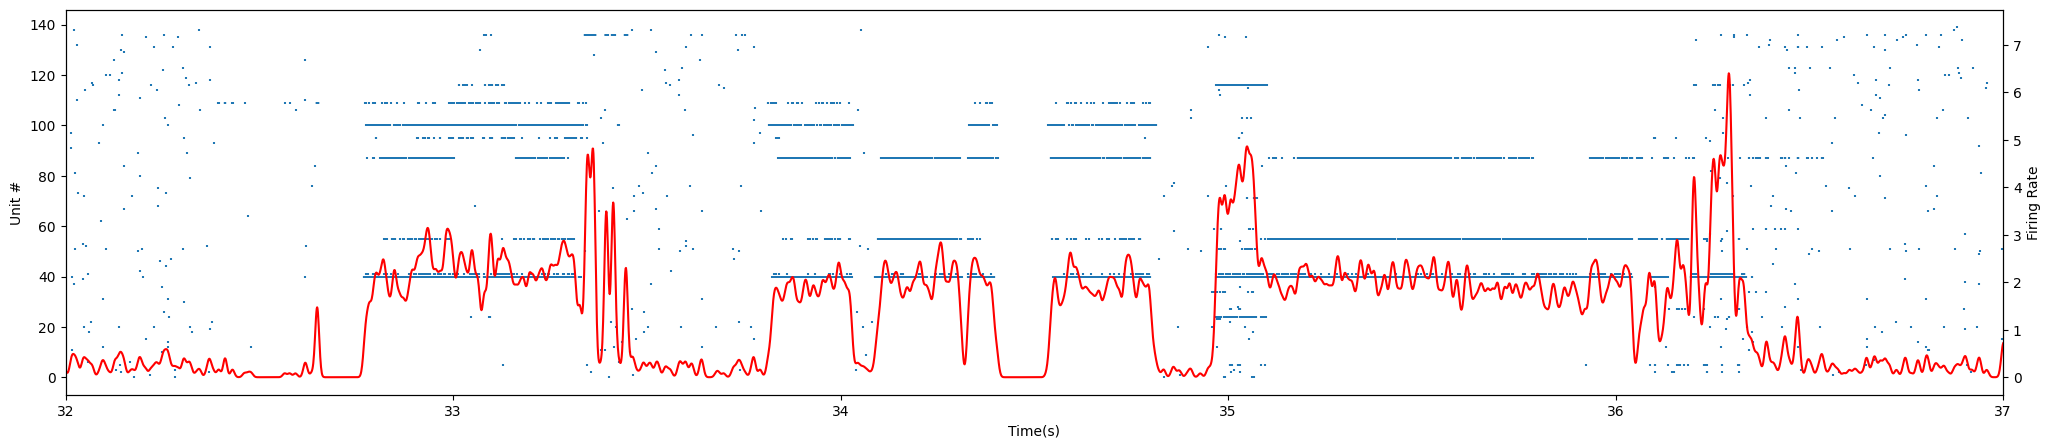

In [8]:
raster_analysis_bounds(sd, xsize = 25, ysize=5, start_time=32, stop_time=37, save_path="Activity32_37")

/tmp/ipykernel_717272/2969079660.py:121: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


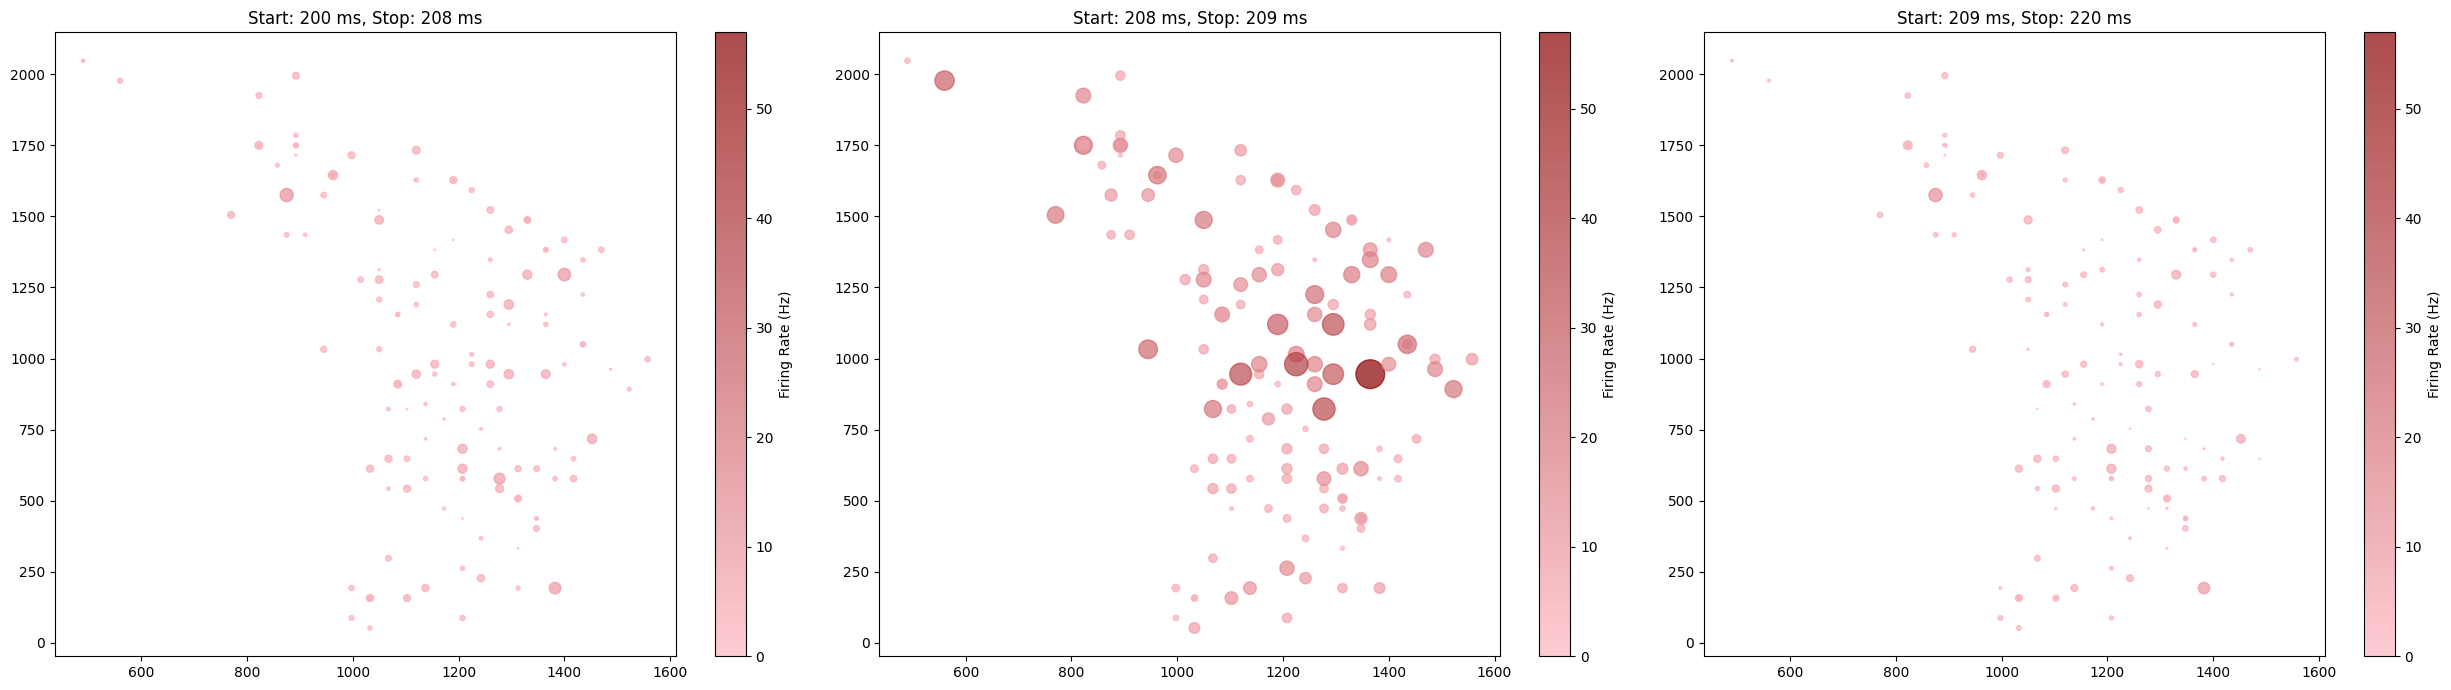

In [9]:
# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

# Define different start and stop values for each subplot
start_values = [200, 208, 209]
stop_values = [208, 209, 220]

# Create a list to store firing_rates for all subplots
firing_rates_list = []

for i, ax in enumerate(axes):
    # Call the analyze_and_plot_firing_rates function for each subplot with the specified axis
    firing_rates = analyze_and_plot_firing_rates(sd, start_values[i], stop_values[i], ax=ax)
    firing_rates_list.append(firing_rates)
    ax.set_title(f"Start: {start_values[i]} ms, Stop: {stop_values[i]} ms")

# Get the minimum and maximum firing rates across all subplots
global_min = min([firing.min() for firing in firing_rates_list])
global_max = max([firing.max() for firing in firing_rates_list])

# # Create a common colorbar for all subplots using vmin and vmax from the global_min and global_max
# cbar = plt.colorbar(axes[0].collections[0], cax=fig.add_axes([0.91, 0.15, 0.02, 0.7]), orientation='vertical')
# cbar.set_label('Firing Rate (Hz)')

# Set the color limits on the scatter plot directly
for ax in axes:
    ax.collections[0].set_clim(vmin=global_min, vmax=global_max)

plt.tight_layout()

plt.savefig("FiringMapsByTime_200")

plt.show()

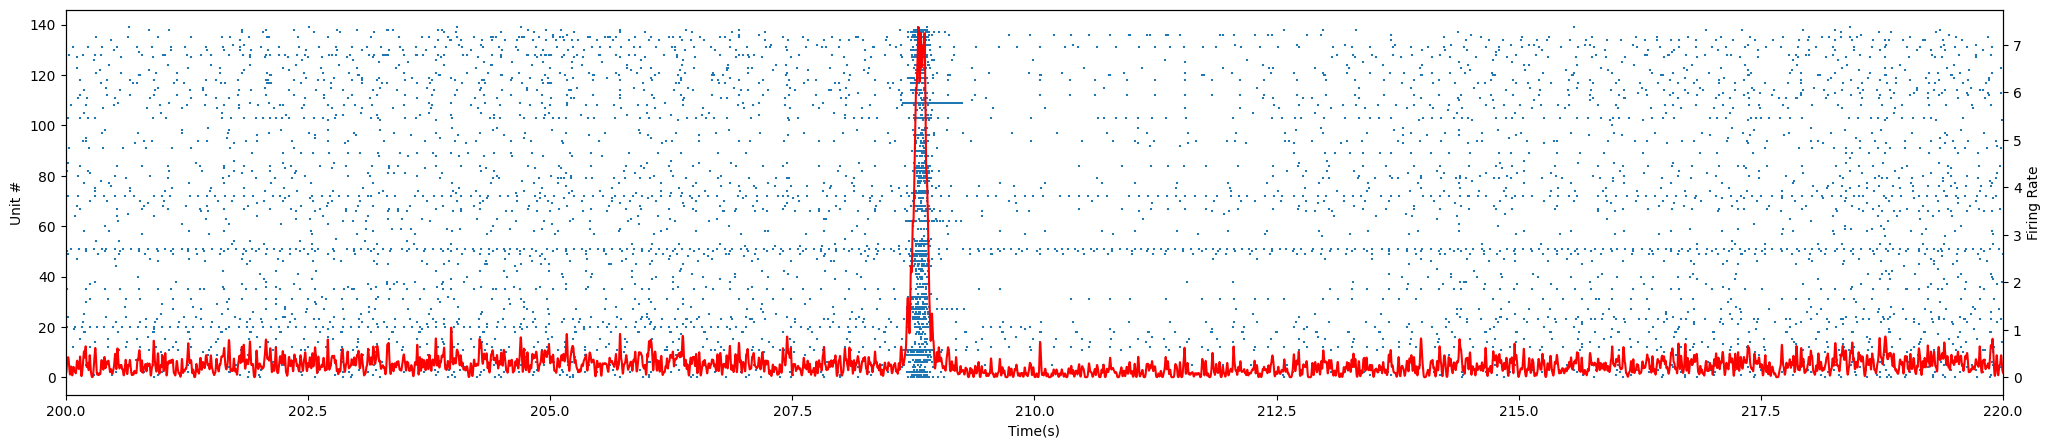

In [10]:
raster_analysis_bounds(sd, xsize = 25, ysize=5, start_time=200, stop_time=220, save_path="Activity200_220")

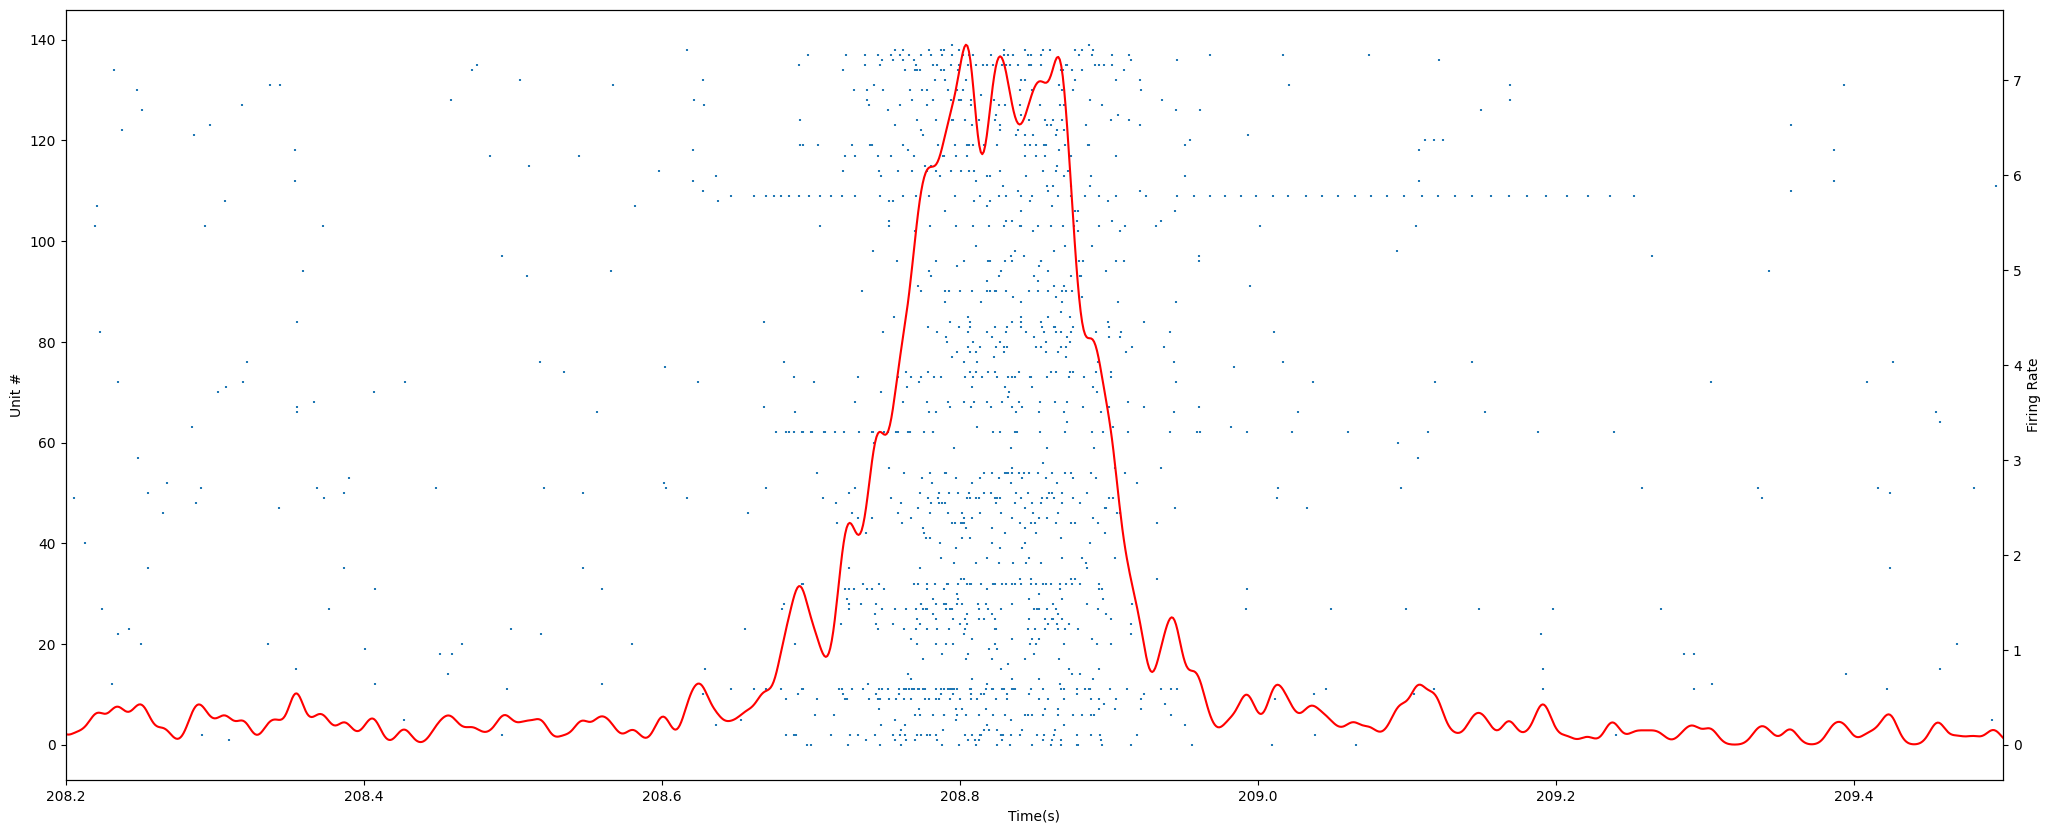

In [11]:
raster_analysis_bounds(sd, xsize = 25, ysize=10, start_time=208.2, stop_time=209.5, save_path="Activity208_209")

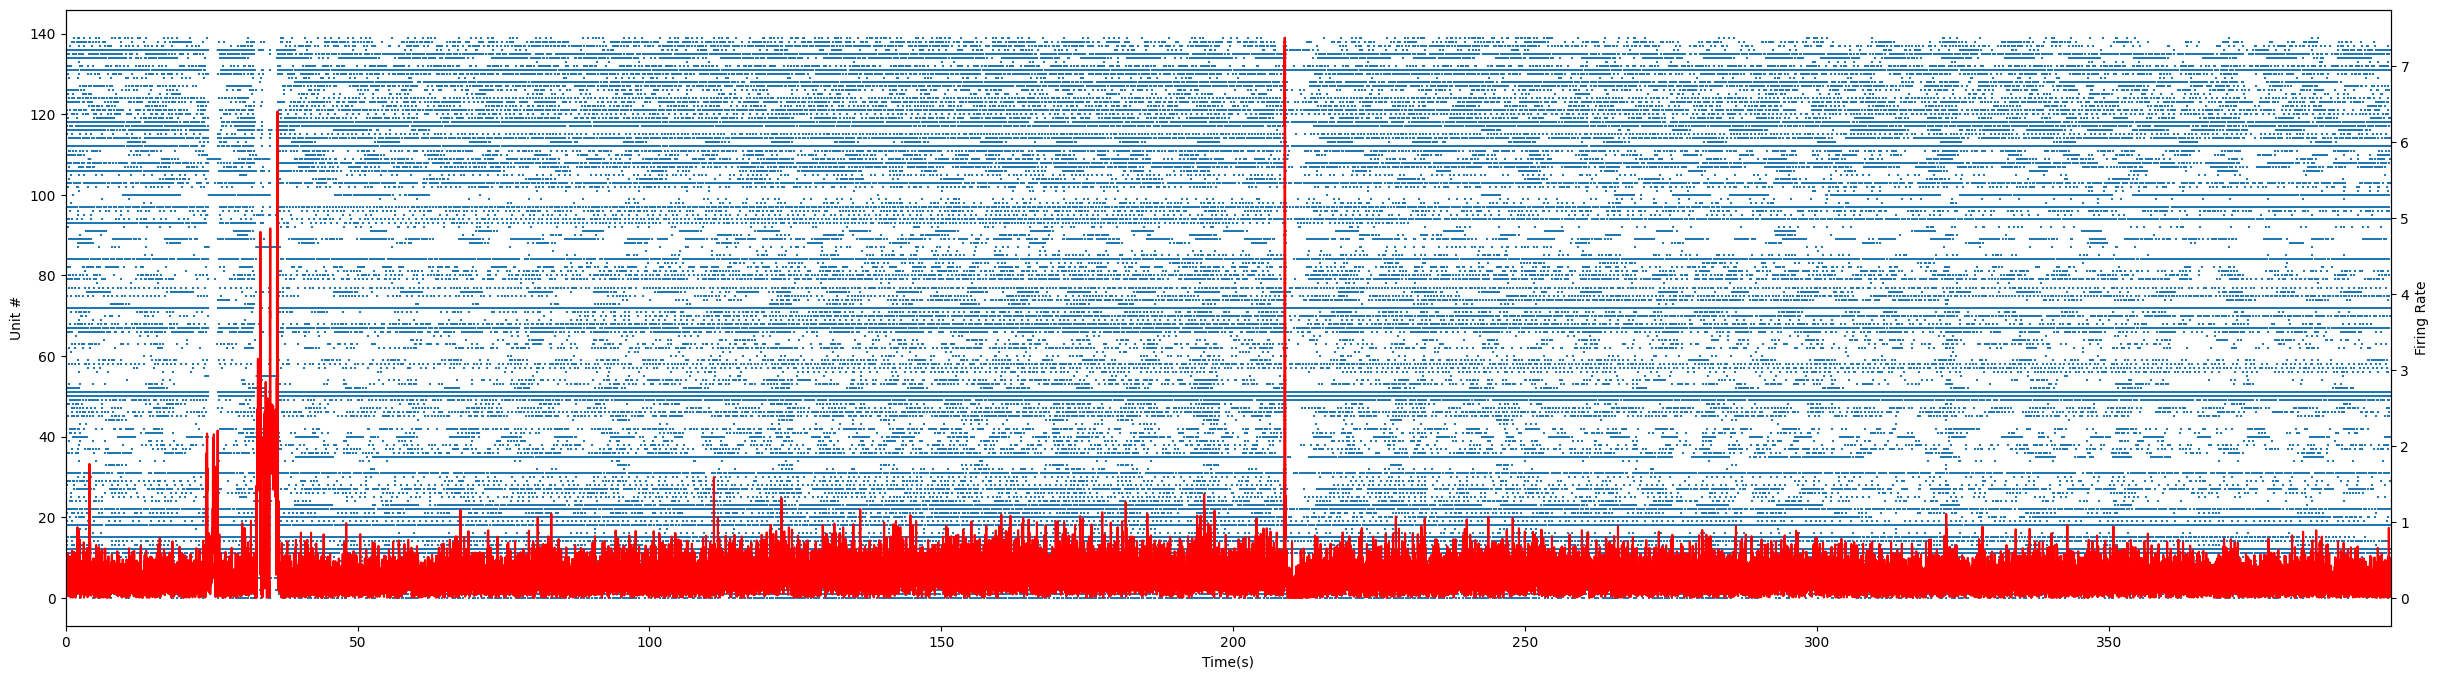

In [31]:
raster_analysis_bounds(sd, xsize = 30, ysize=8, start_time=0, stop_time=sd.length/1000, save_path="ActivityAll")

/tmp/ipykernel_717272/2969079660.py:121: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


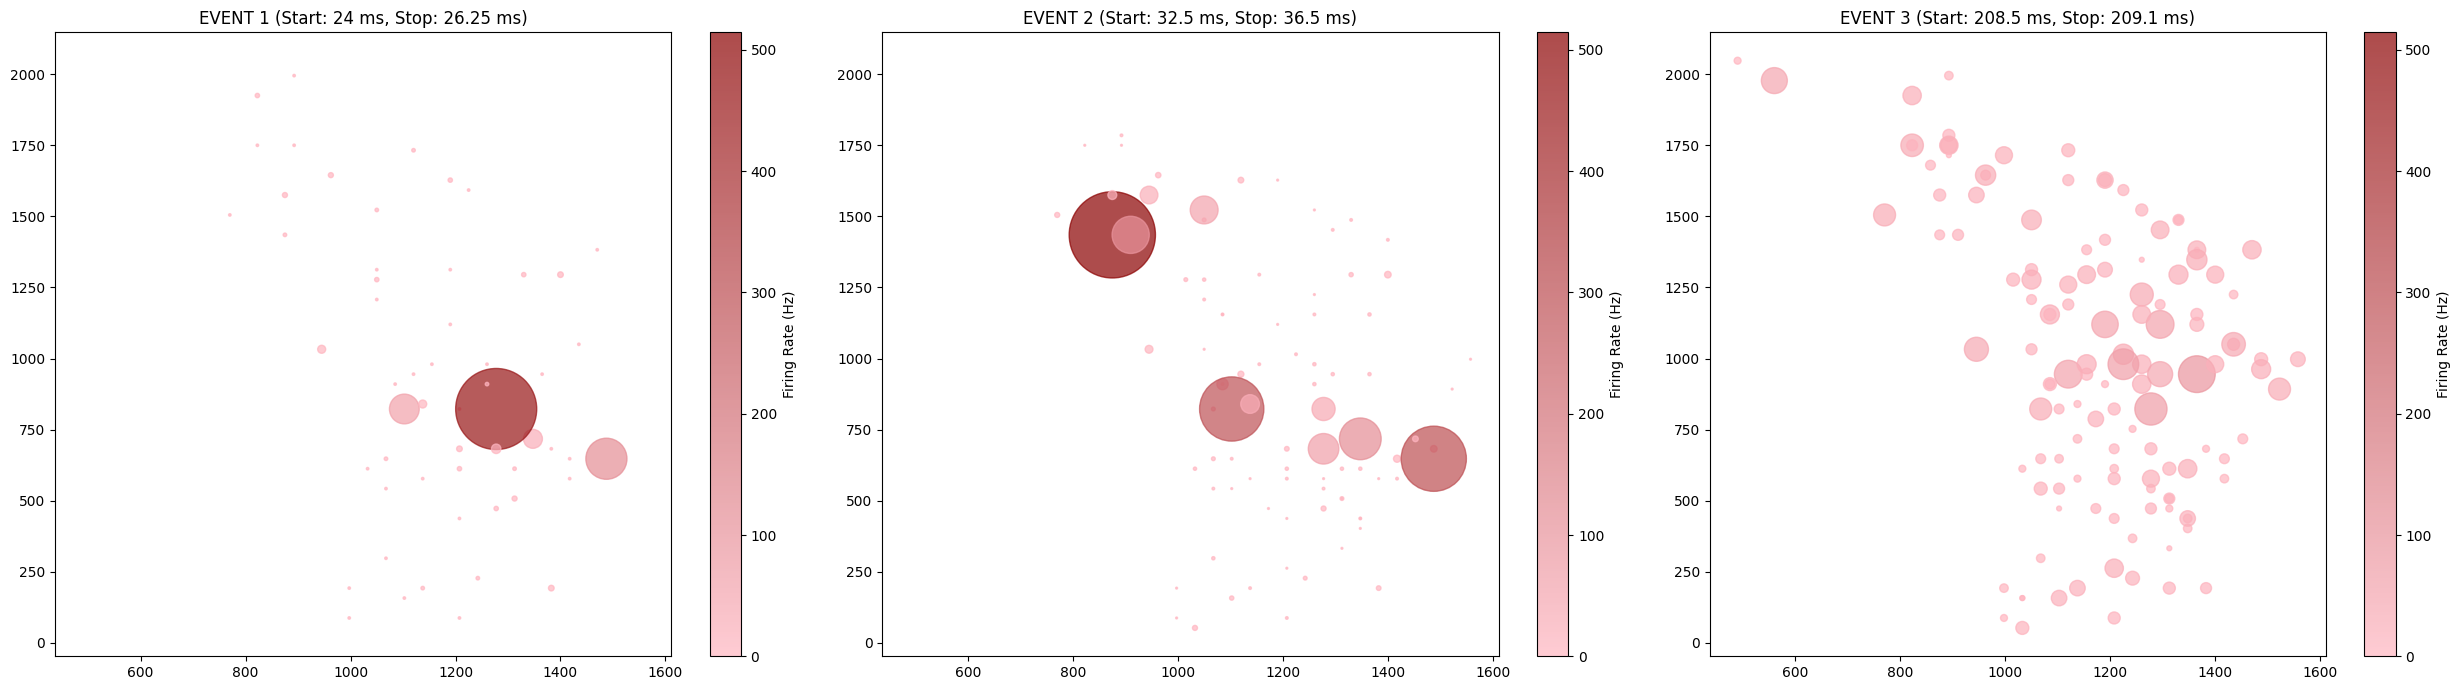

In [12]:
# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

# Define different start and stop values for each subplot
start_values = [24, 32.5, 208.5]
stop_values = [26.25, 36.5, 209.1]

# Create a list to store firing_rates for all subplots
firing_rates_list = []

for i, ax in enumerate(axes):
    # Call the analyze_and_plot_firing_rates function for each subplot with the specified axis
    firing_rates = analyze_and_plot_firing_rates(sd, start_values[i], stop_values[i], ax=ax)
    firing_rates_list.append(firing_rates)
    ax.set_title(f"EVENT {i+1} (Start: {start_values[i]} ms, Stop: {stop_values[i]} ms)")

# Get the minimum and maximum firing rates across all subplots
global_min = min([firing.min() for firing in firing_rates_list])
global_max = max([firing.max() for firing in firing_rates_list])

# # Create a common colorbar for all subplots using vmin and vmax from the global_min and global_max
# cbar = plt.colorbar(axes[0].collections[0], cax=fig.add_axes([0.91, 0.15, 0.02, 0.7]), orientation='vertical')
# cbar.set_label('Firing Rate (Hz)')

# Set the color limits on the scatter plot directly
for ax in axes:
    ax.collections[0].set_clim(vmin=global_min, vmax=global_max)

plt.tight_layout()

plt.savefig("FiringMapsByEvent")

plt.show()

/tmp/ipykernel_717272/2969079660.py:121: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


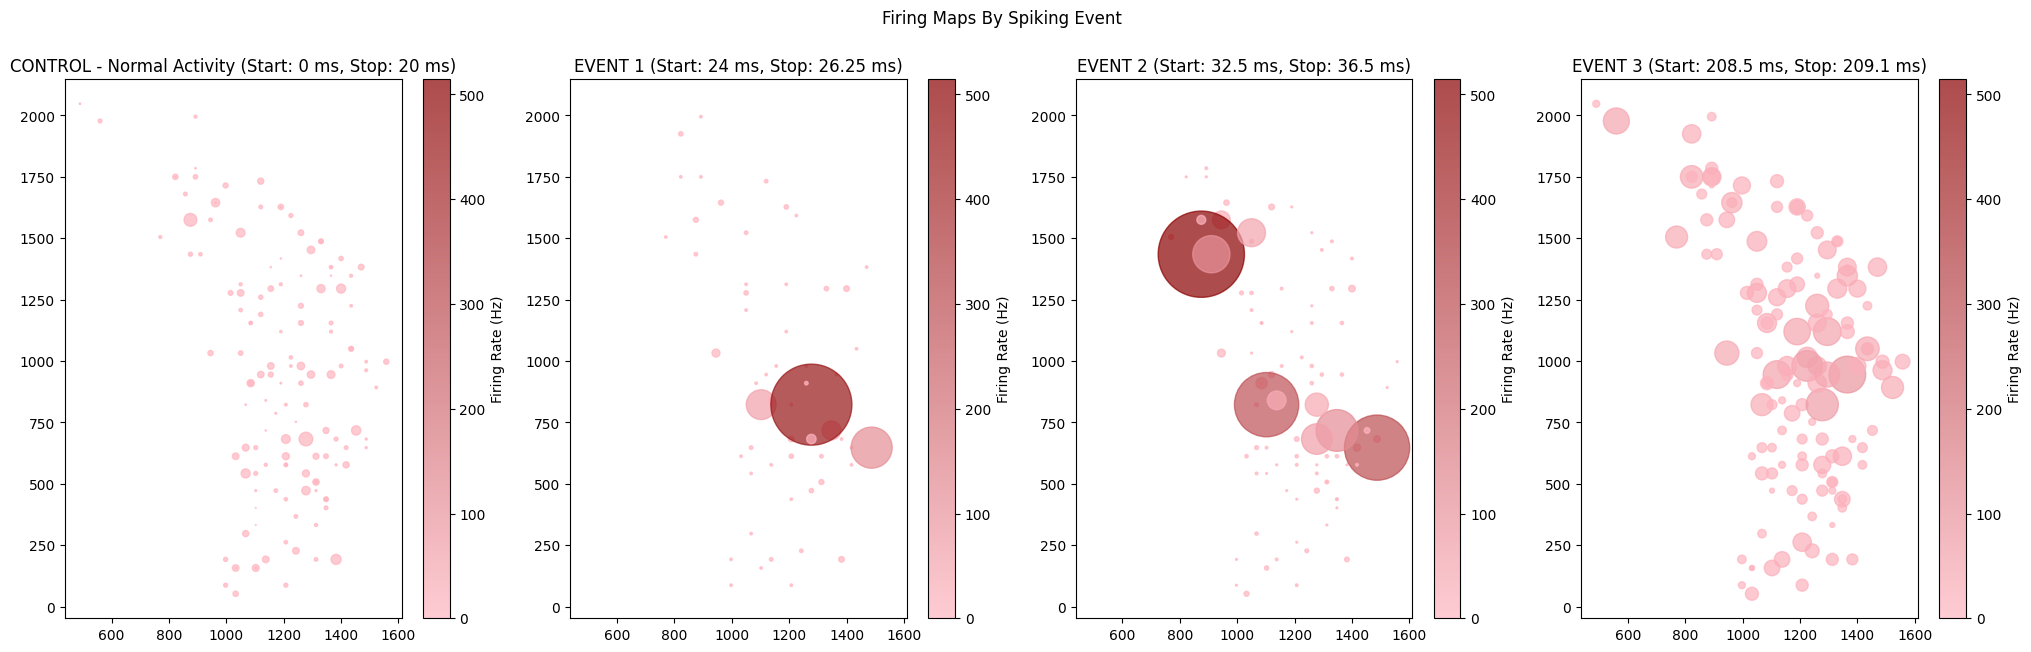

In [14]:
# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(25, 7))

# Define different start and stop values for each subplot
start_values = [0, 24, 32.5, 208.5]
stop_values = [20, 26.25, 36.5, 209.1]

# Create a list to store firing_rates for all subplots
firing_rates_list = []

for i, ax in enumerate(axes):
    # Call the analyze_and_plot_firing_rates function for each subplot with the specified axis
    firing_rates = analyze_and_plot_firing_rates(sd, start_values[i], stop_values[i], ax=ax)
    firing_rates_list.append(firing_rates)
    ax.set_title(f"EVENT {i} (Start: {start_values[i]} ms, Stop: {stop_values[i]} ms)")
    if i == 0:
        ax.set_title(f"CONTROL - Normal Activity (Start: {start_values[i]} ms, Stop: {stop_values[i]} ms)")
    
# Get the minimum and maximum firing rates across all subplots
global_min = min([firing.min() for firing in firing_rates_list])
global_max = max([firing.max() for firing in firing_rates_list])

# # Create a common colorbar for all subplots using vmin and vmax from the global_min and global_max
# cbar = plt.colorbar(axes[0].collections[0], cax=fig.add_axes([0.91, 0.15, 0.02, 0.7]), orientation='vertical')
# cbar.set_label('Firing Rate (Hz)')

# Set the color limits on the scatter plot directly
for ax in axes:
    ax.collections[0].set_clim(vmin=global_min, vmax=global_max)

plt.suptitle("Firing Maps By Spiking Event")

plt.savefig("FiringMapsByEvent")

plt.show()

In [ ]:
start_values = [0, 23, 26, 32, 36]
stop_values = [23, 26, 32, 36, 50]
start_values = [200, 208, 209]
stop_values = [208, 209, 220]

In [10]:
datapath = '/home/jovyan/work/Human_Hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip'

In [ ]:
fcm.FCM_Plotter(datapath, 0, sd.length/1000, "Full Plot", 0.4, 20, 0.3, saved="No")

140 140


In [13]:
fcm.FCM_Plotter(datapath, 23, 26, "23 - 26 seconds", 0.4, 20, 0.8, saved="Yes")

86 86


In [14]:
fcm.FCM_Plotter(datapath, 26, 32, "26 - 32 seconds", 0.4, 20, 0.8, saved="Yes")

109 109


In [15]:
fcm.FCM_Plotter(datapath, 32, 36, "32 - 36 seconds", 0.4, 20, 0.8, saved="Yes")

93 93


In [16]:
fcm.FCM_Plotter(datapath, 36, 50, "36 - 50 seconds", 0.4, 20, 0.8, saved="Yes")

116 116


In [18]:
fcm.FCM_Plotter(datapath, 200, 208, "200 - 208 seconds", 0.4, 20, 0.8, saved="Yes")

129 129


In [23]:
fcm.FCM_Plotter(datapath, 208, 209, "208 - 209 seconds", 0.4, 20, 0.8, saved="Yes")

130 130


In [20]:
fcm.FCM_Plotter(datapath, 209, 220, "209 - 220 seconds", 0.4, 20, 0.8, saved="Yes")

127 127


# Saved Figures

## Overview Figure

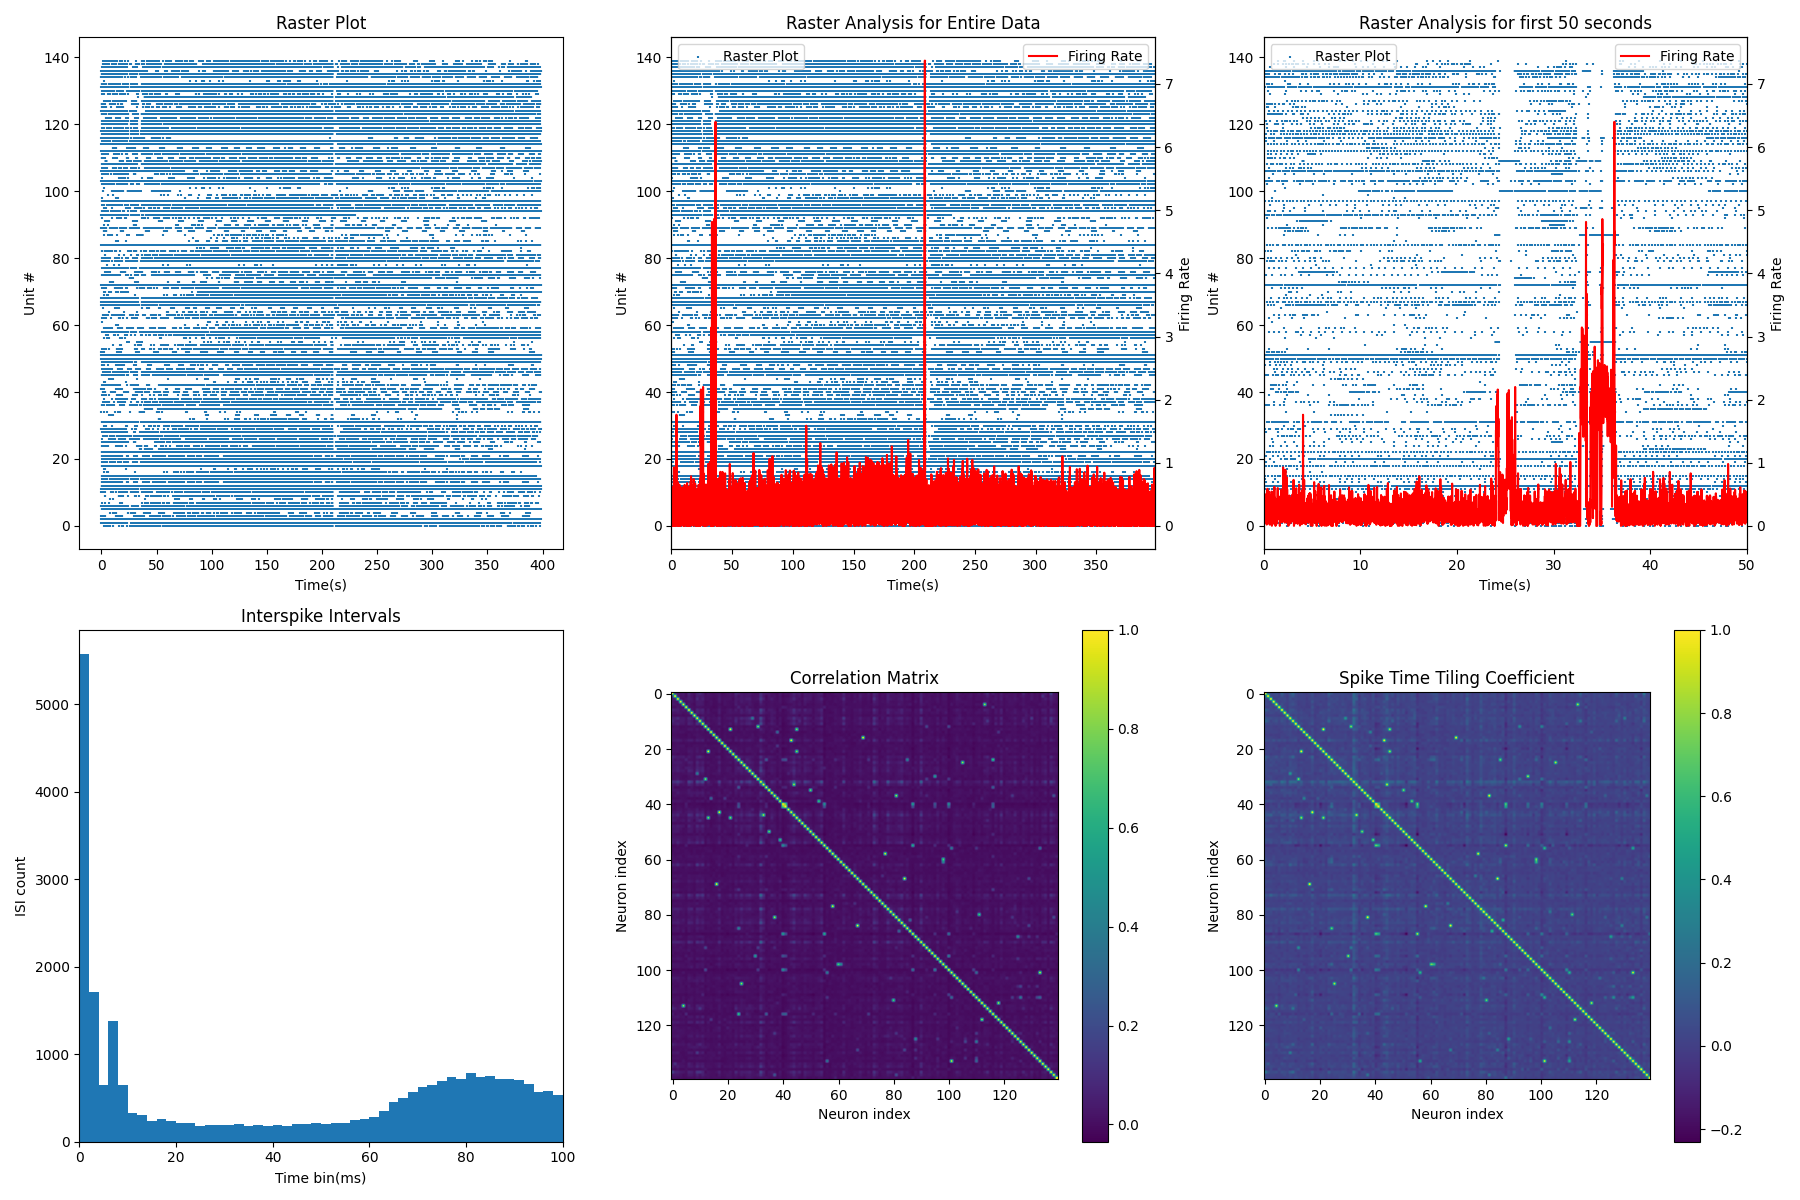

## Firing Maps

### 0 - 50 seconds

Raster Analysis and Firing Rate Map

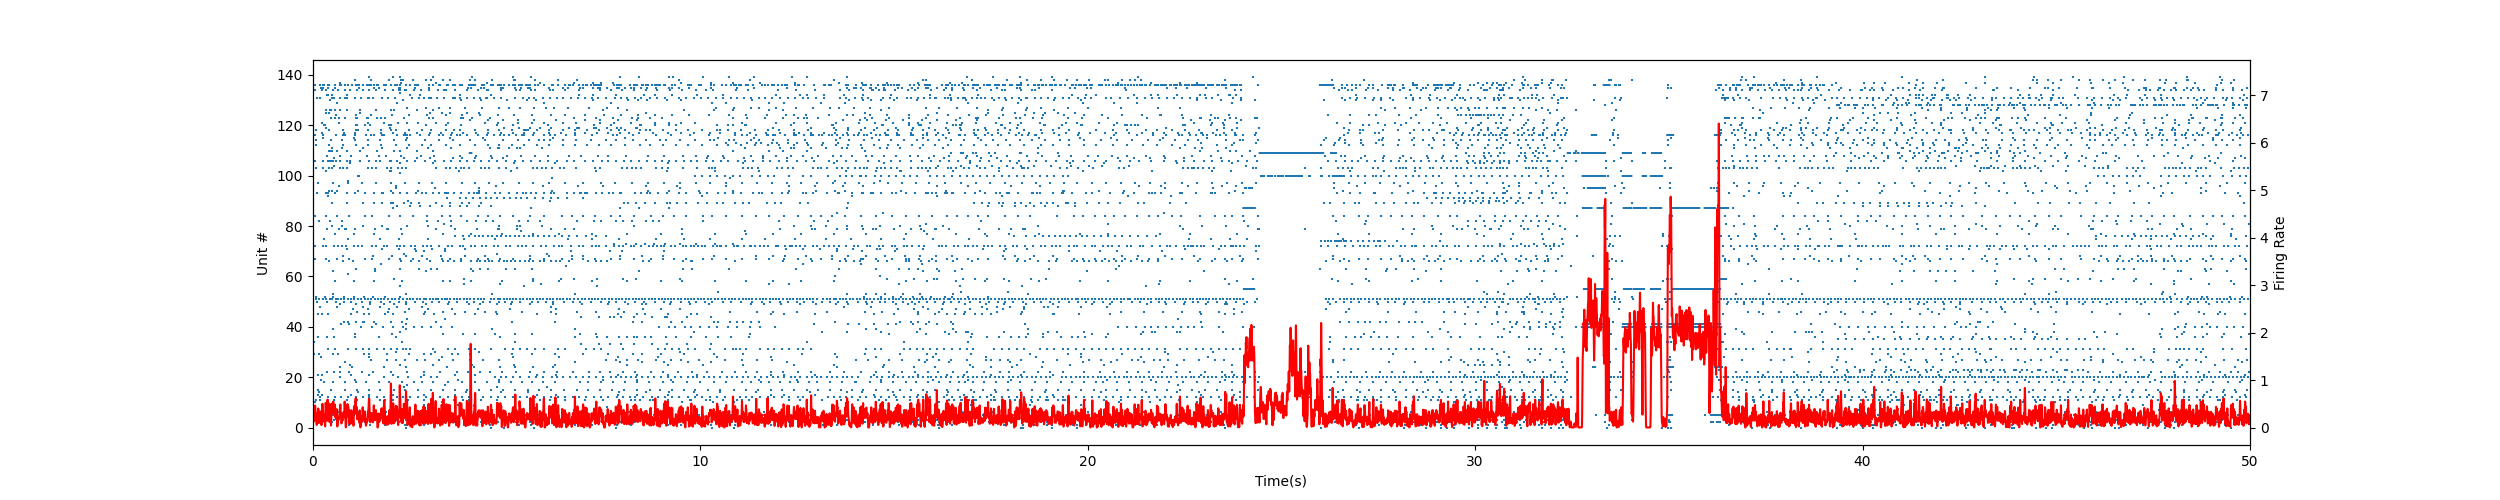
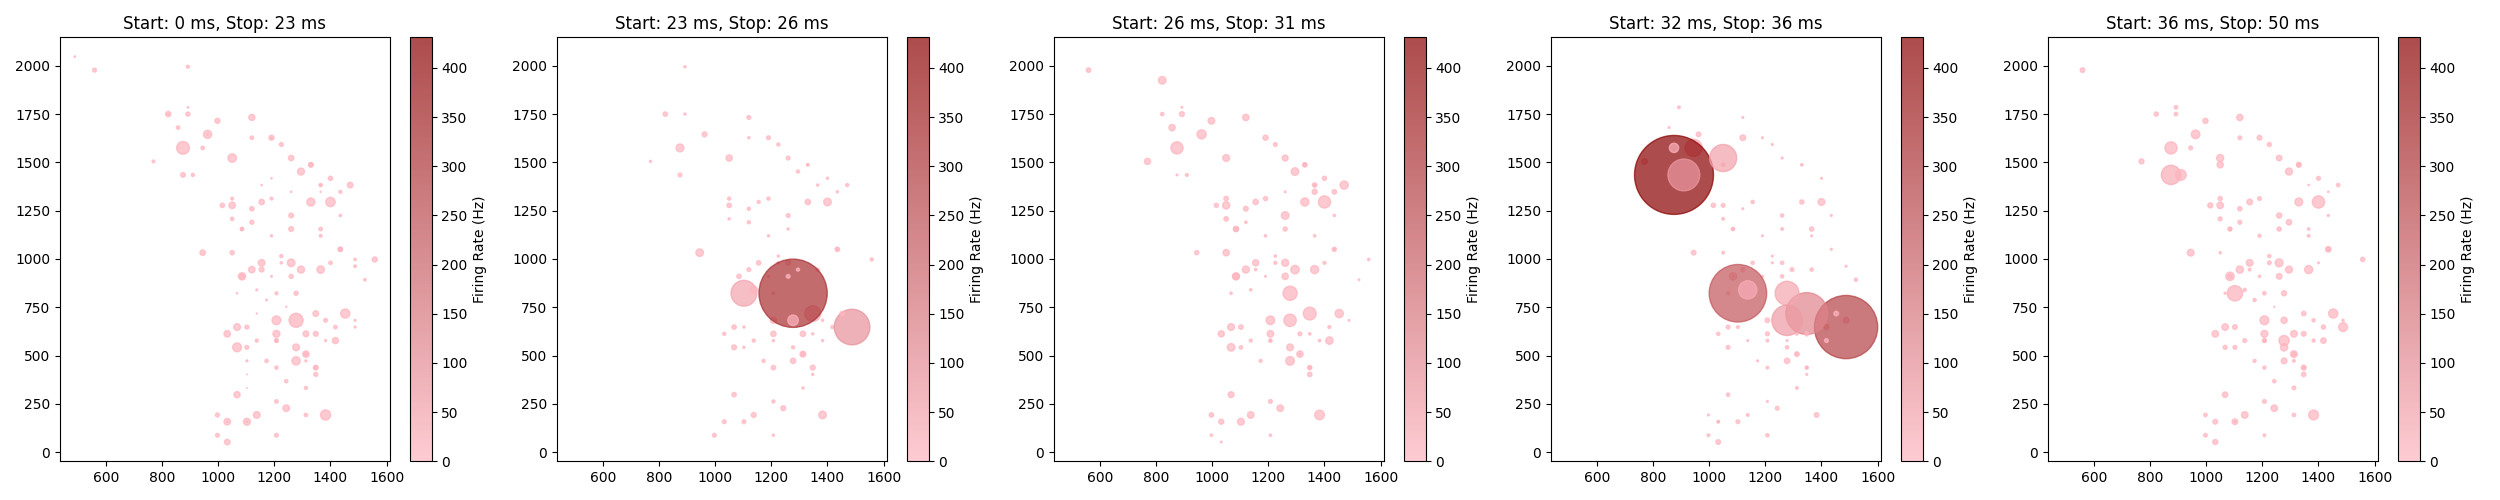

Raster Analysis for each "seizing" event

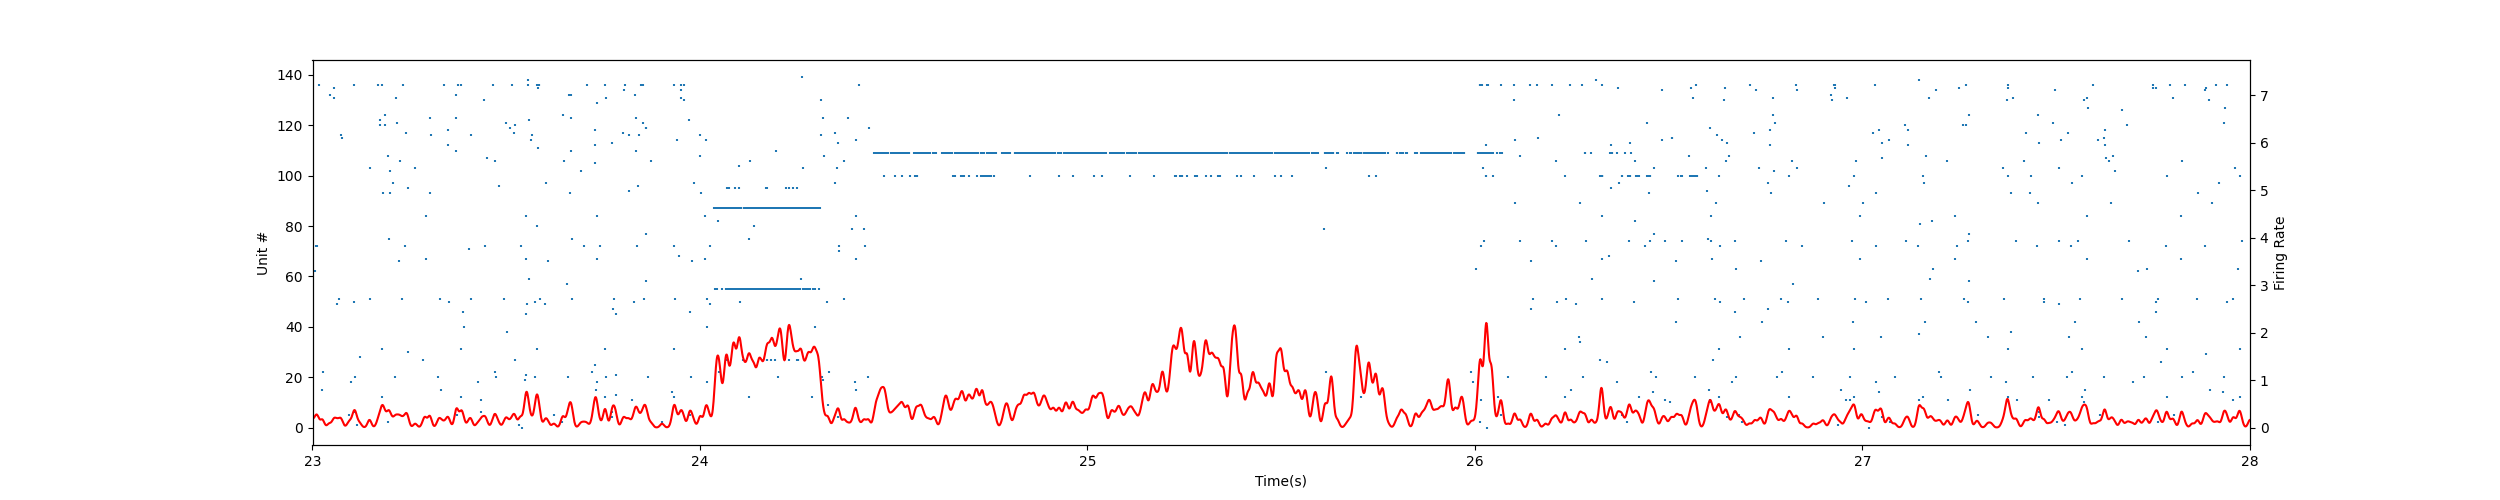
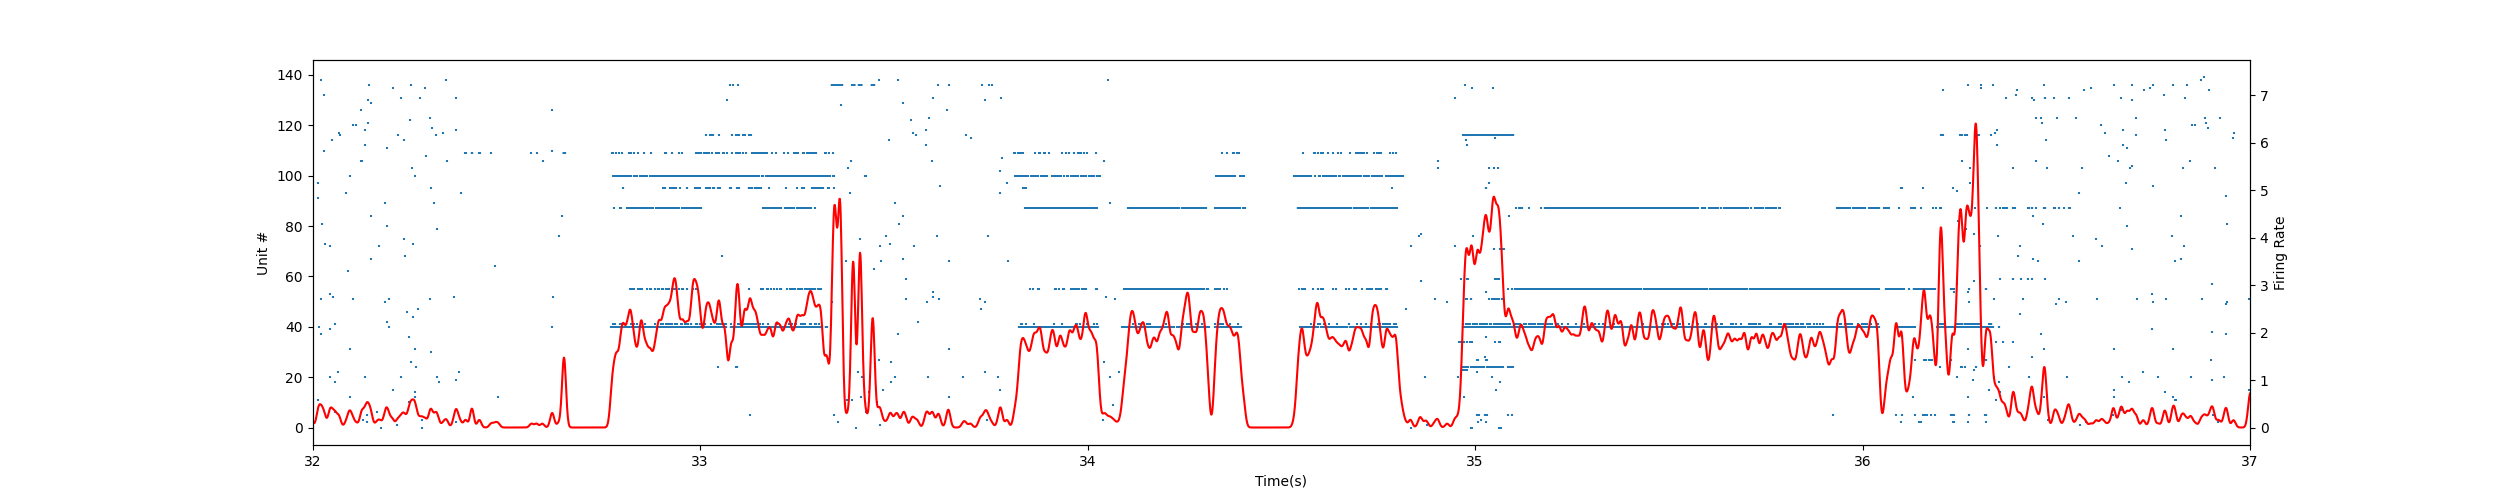

### 200 - 220 seconds

Raster Analysis and Firing Rate Map

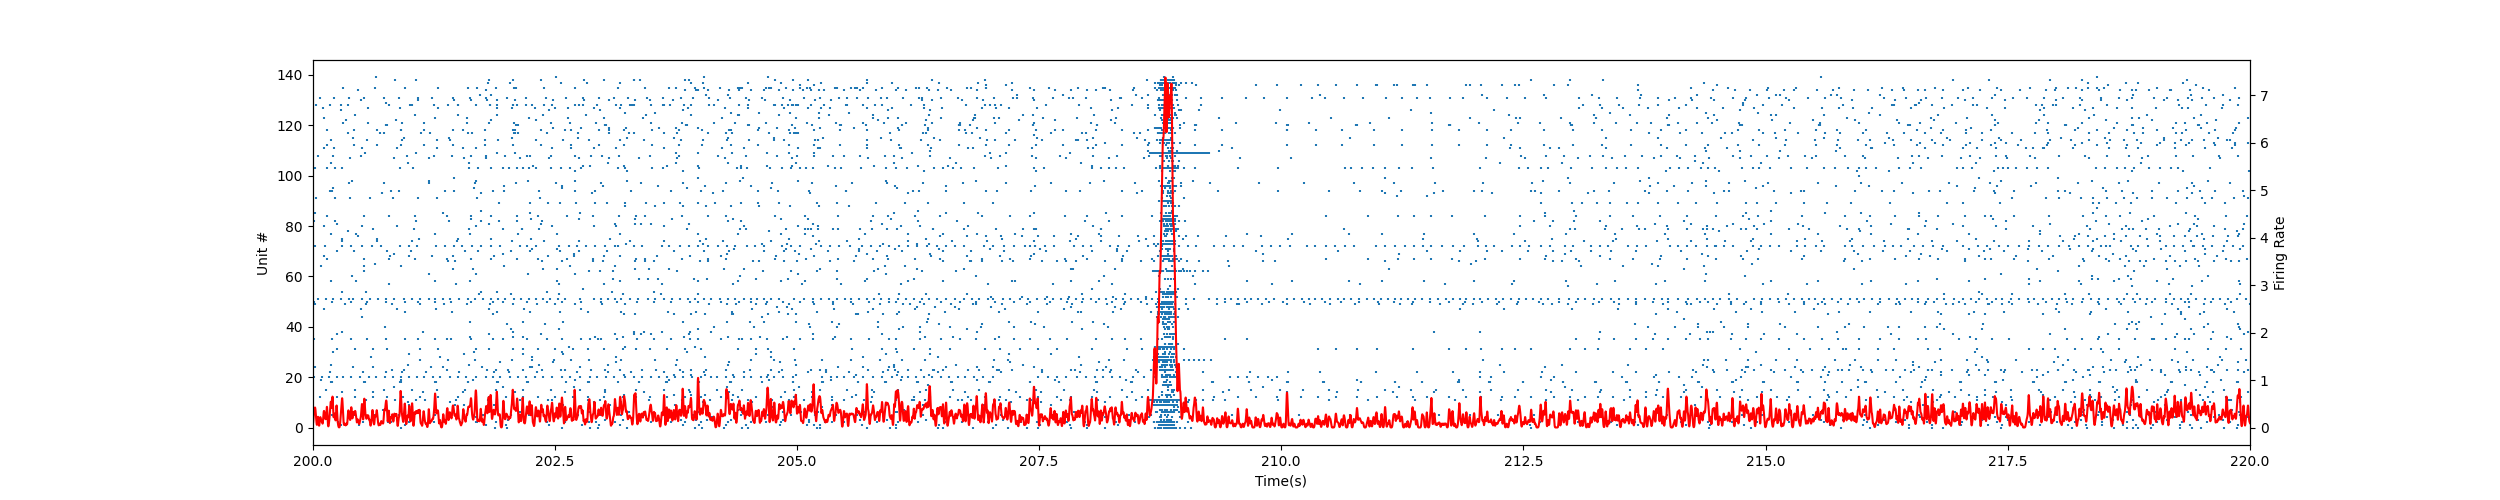
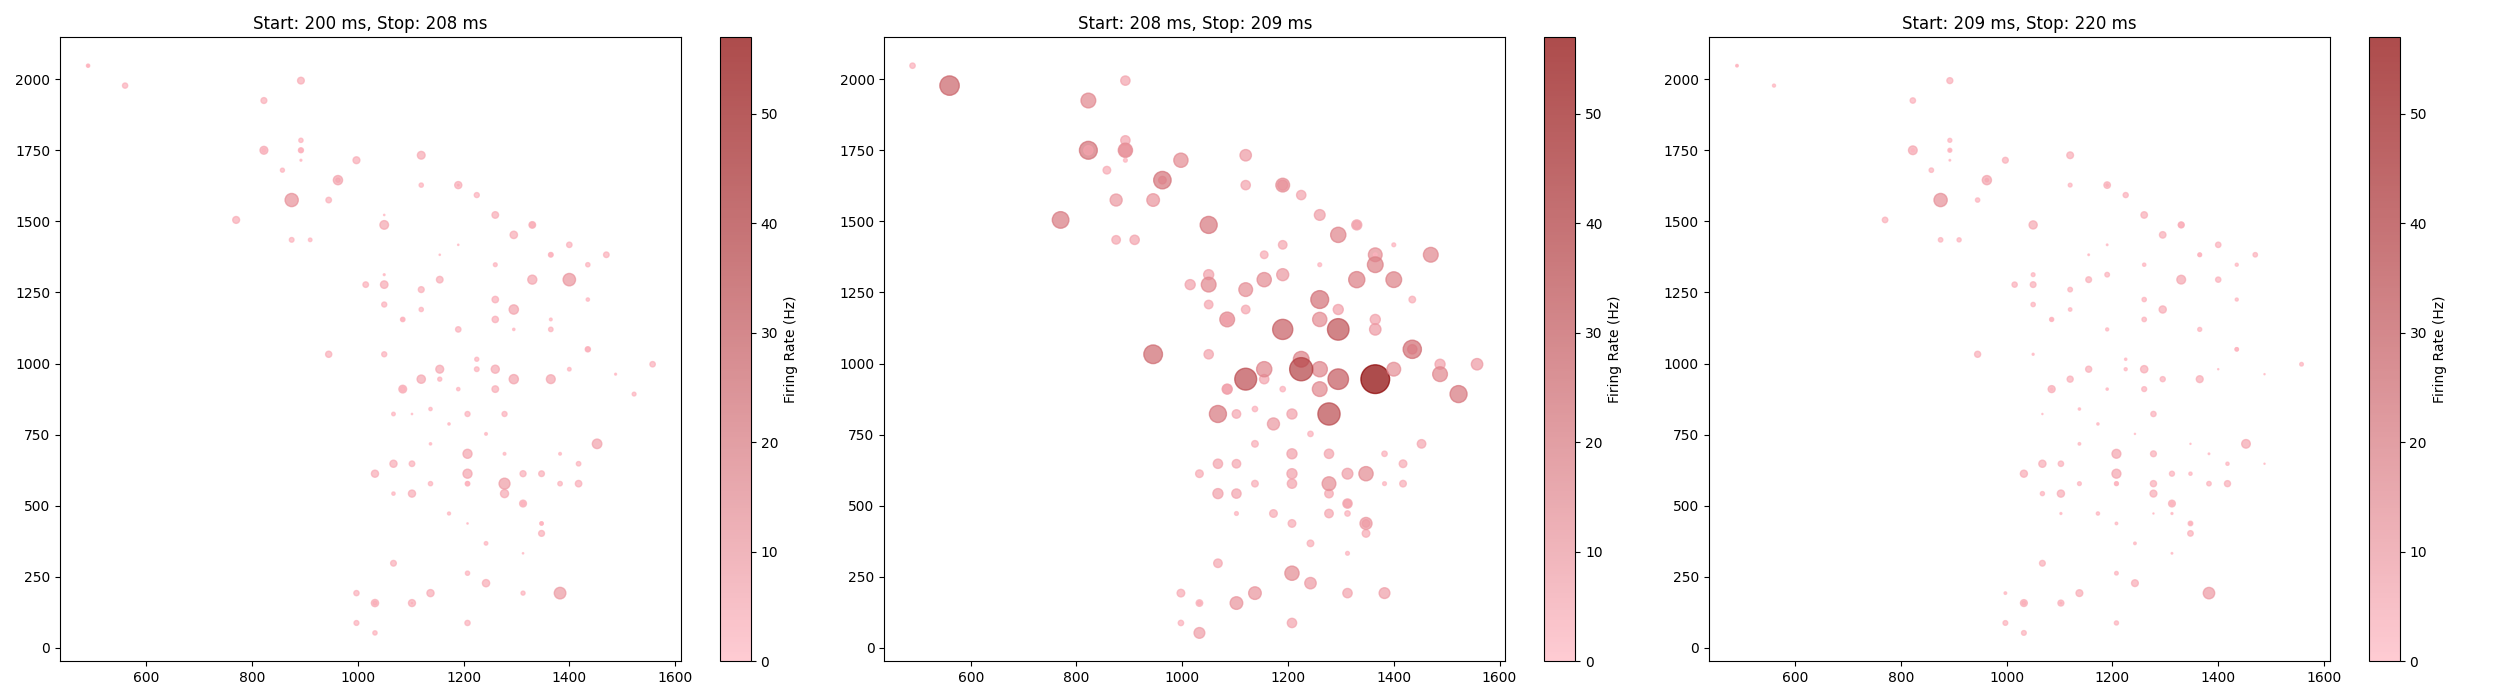

Raster Analysis for "seizing" event

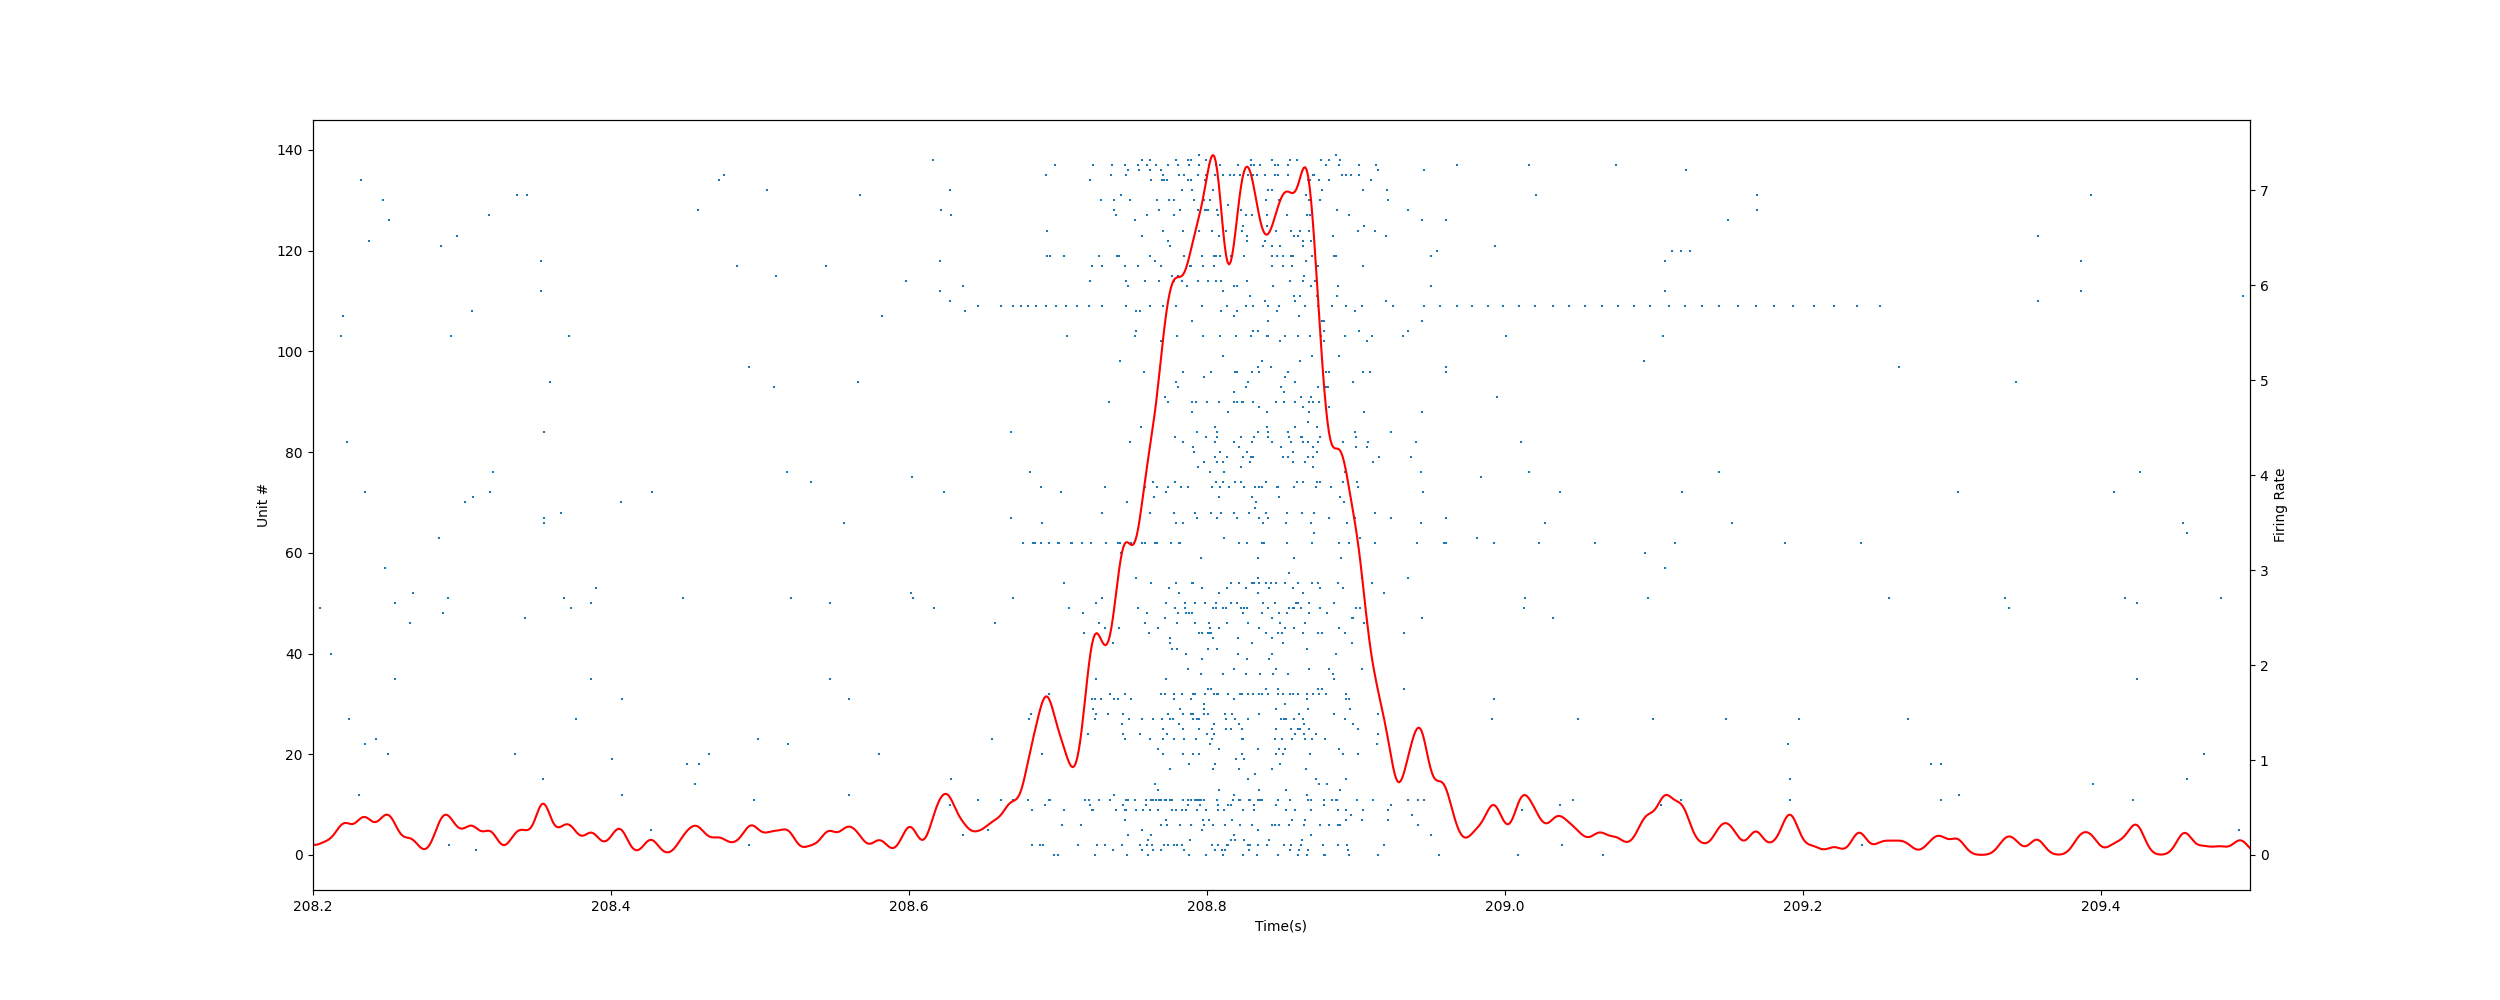

### Firing Maps Compared Across Seizing Events

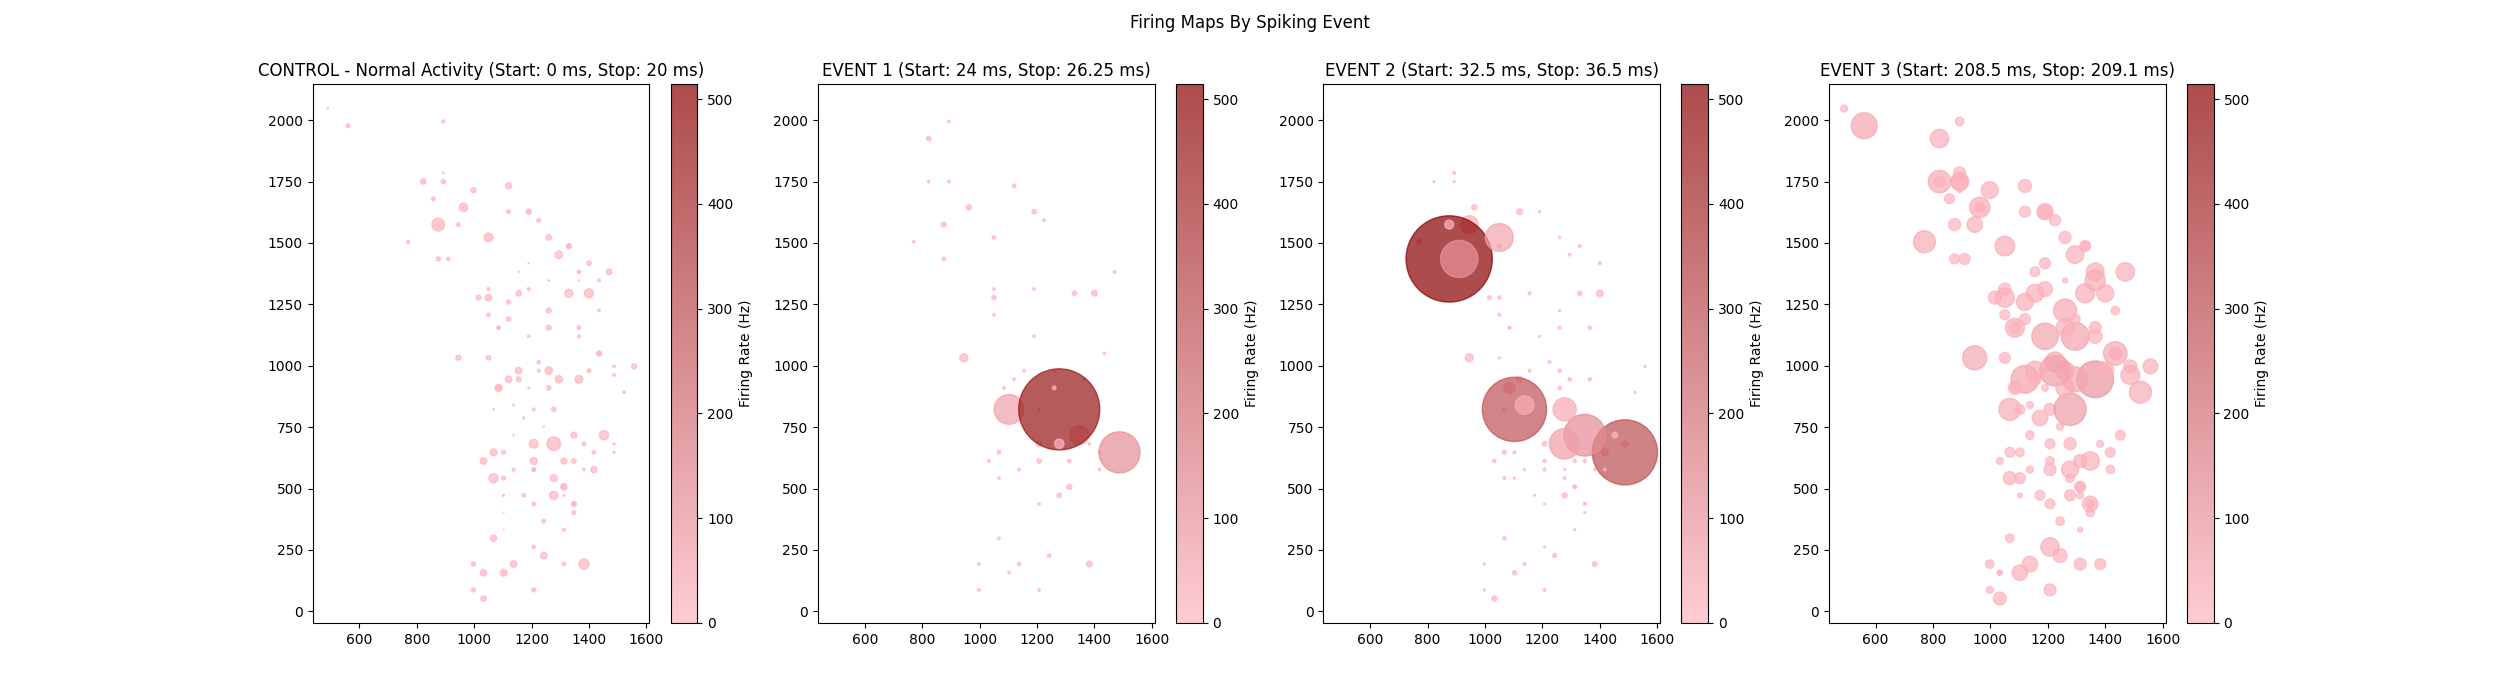

## Functional Connectivity Maps

Entire Recording

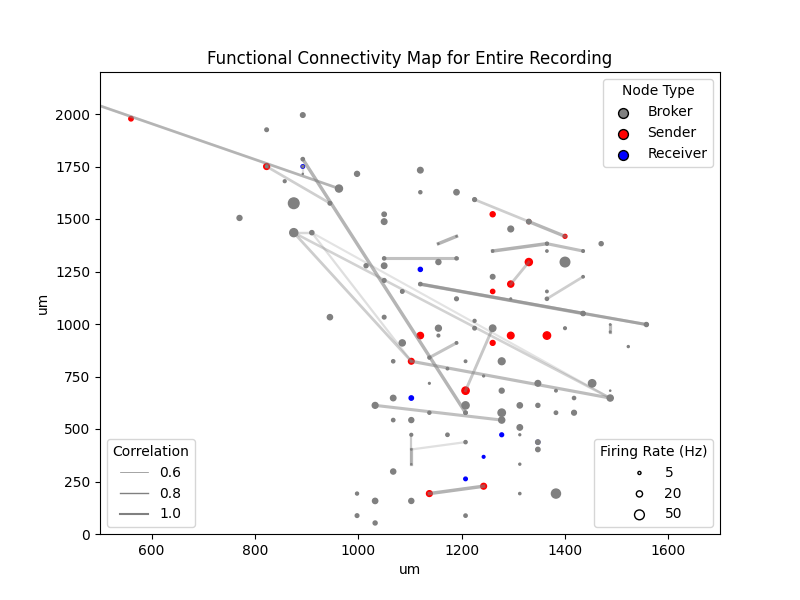

First Events

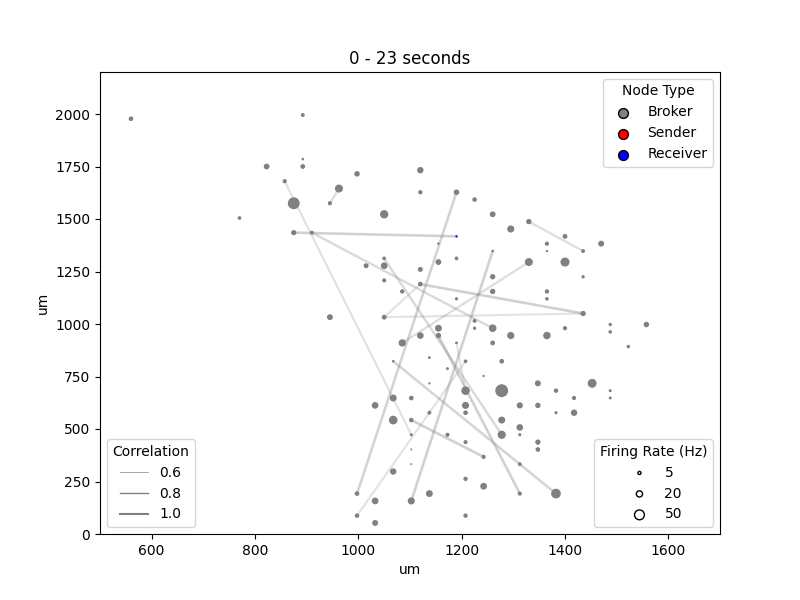

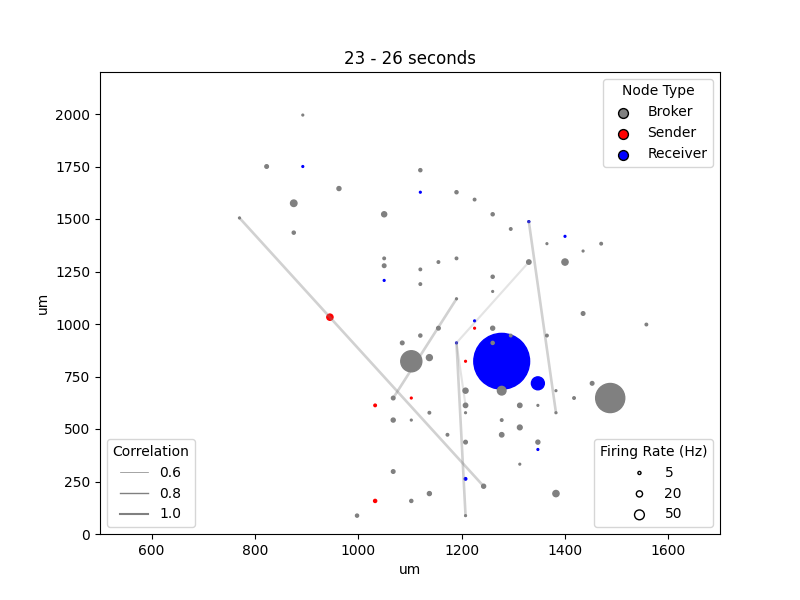

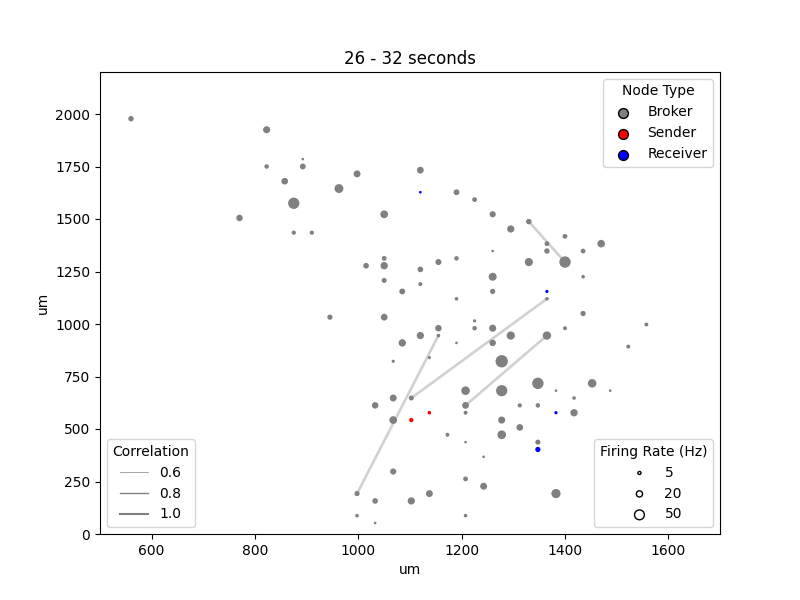

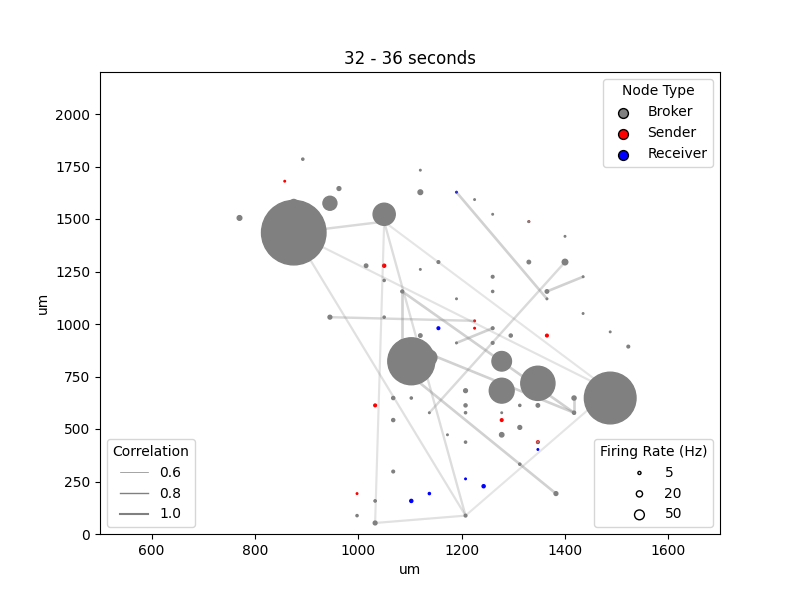

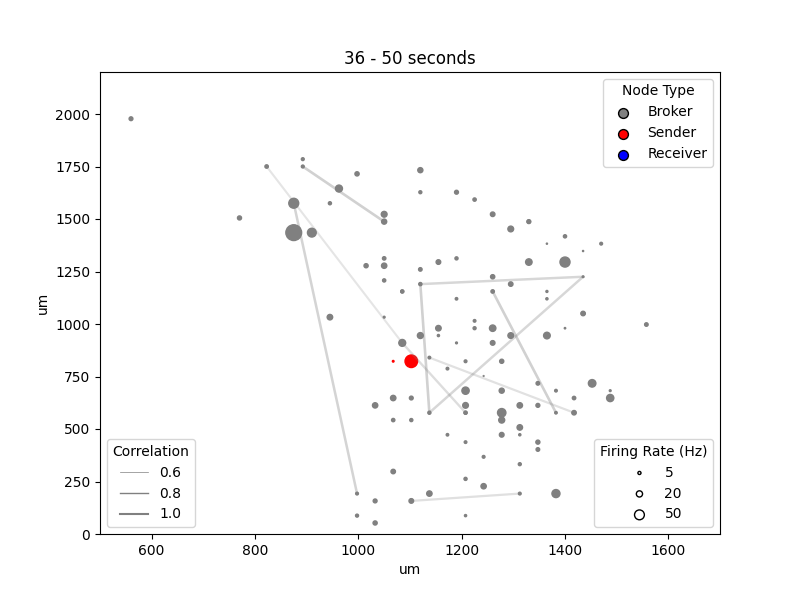

Second Event

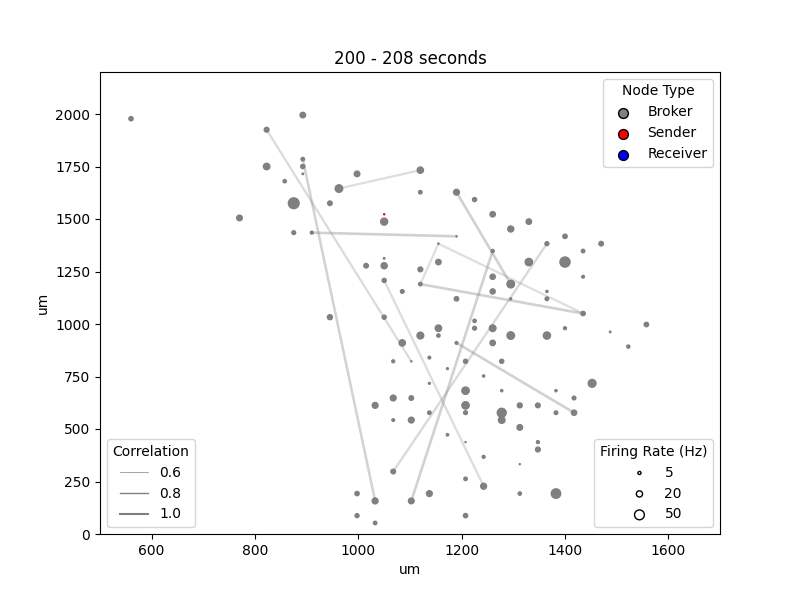

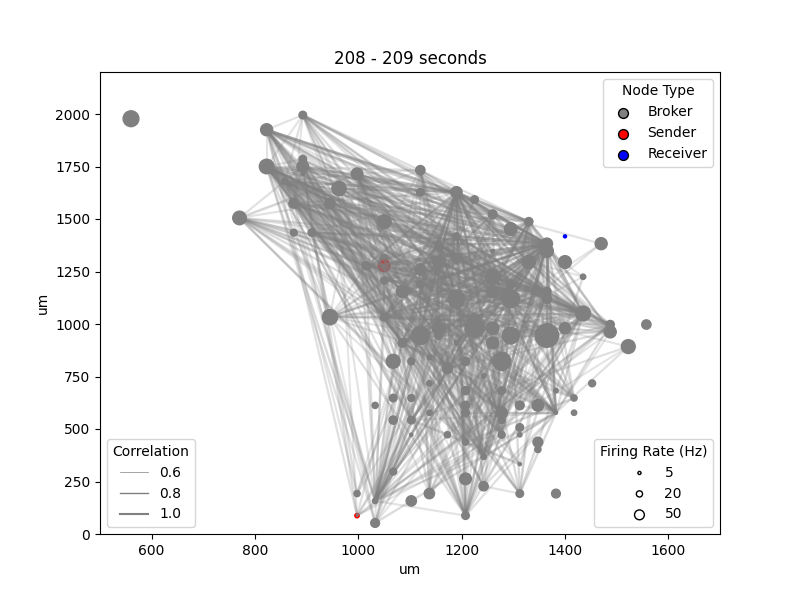

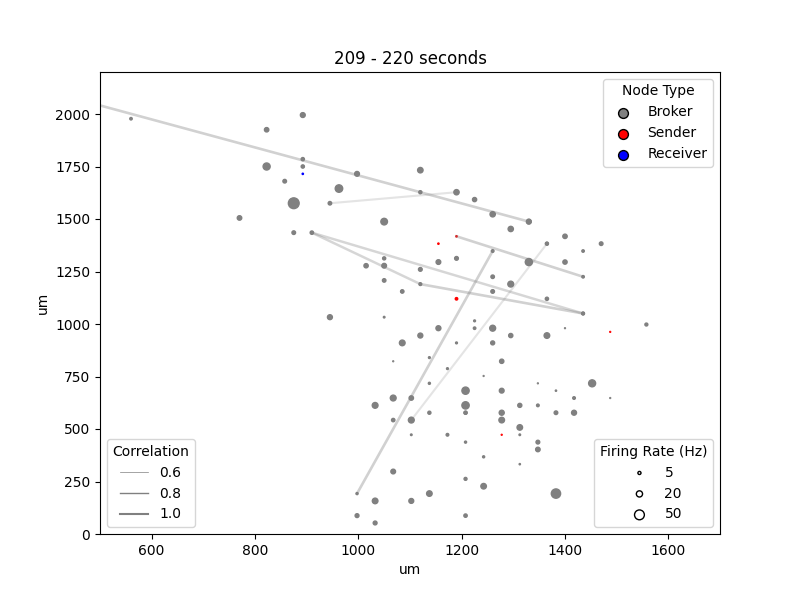

## Animations

### Firing Maps

http://54.183.203.115:8810/files/work/Human_Hippocampus/saved_plots/firing_animations/New_Data/new_data.gif

## Latency Distributions

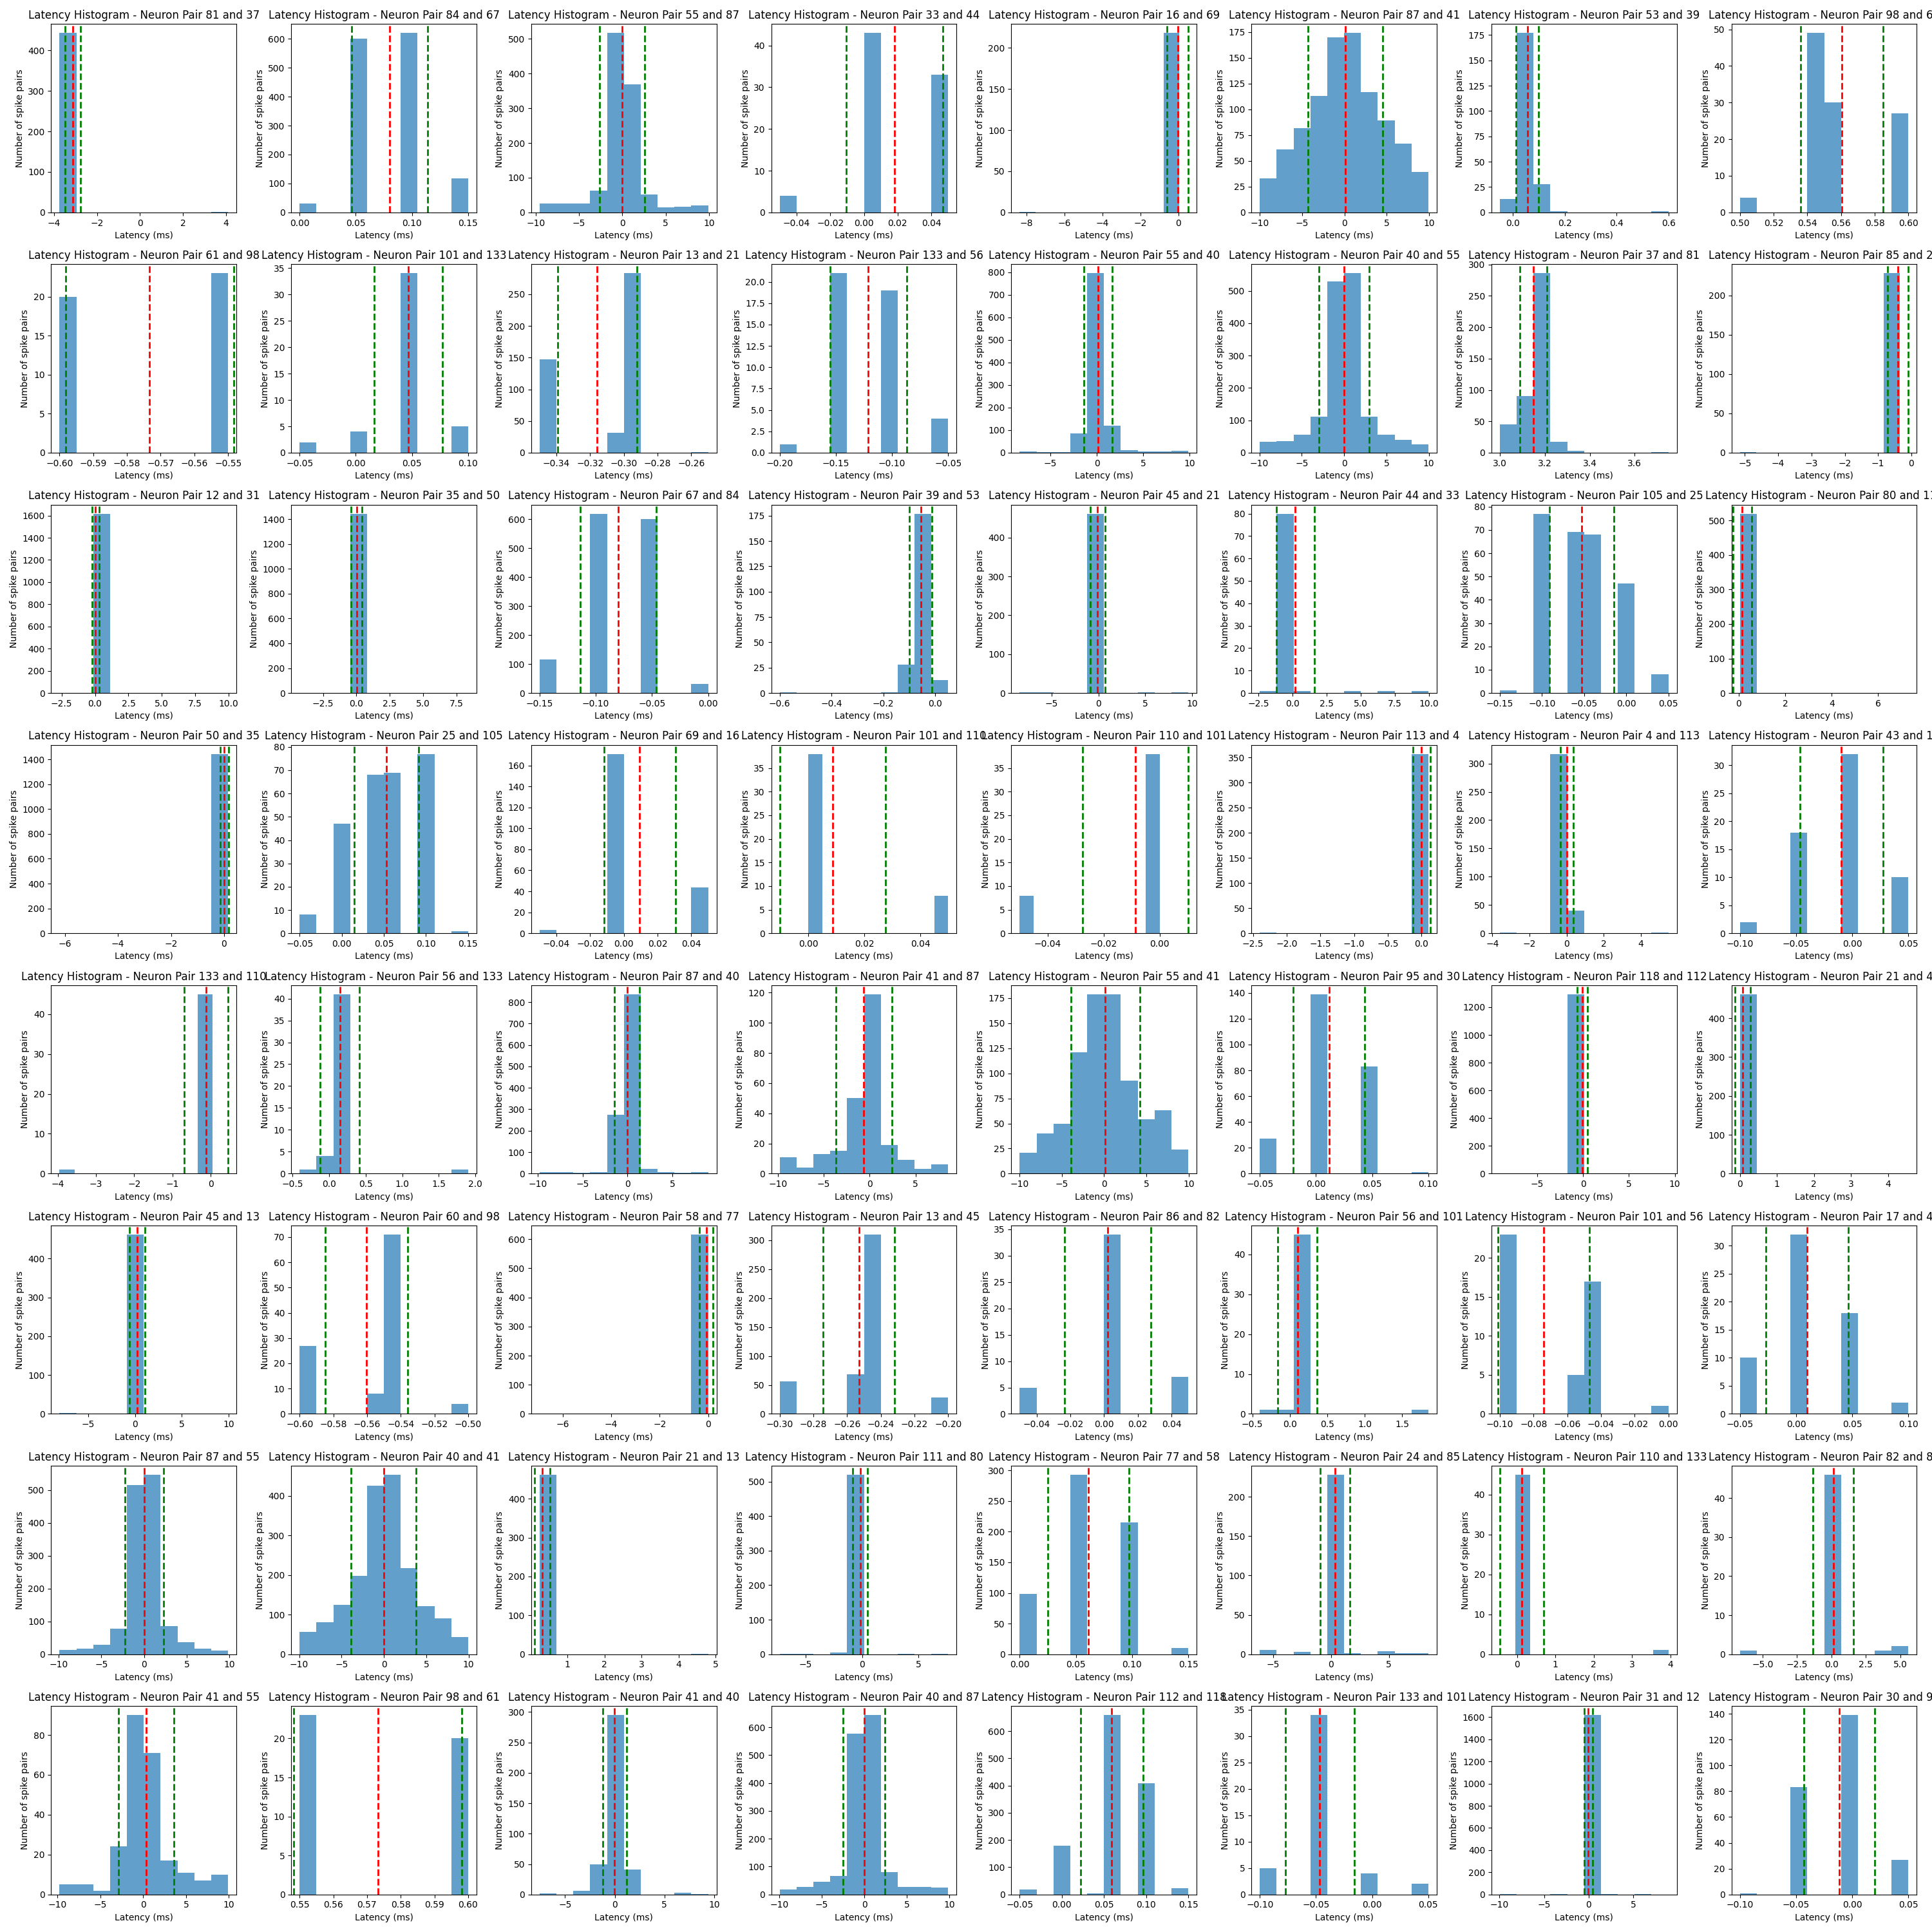